## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

`###############################################################################`

**ANSWER:** Output volume dimensions for 'VALID' padding (https://www.tensorflow.org/api_guides/python/nn#Convolution):

```python
out_height = ceil(float(in_height - filter_height + 1) / float(strides[1])) = ceil((32 - 7 + 1) / 2) = ceil(13) = 13
out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2])) = ceil((32 - 7 + 1) / 2) = ceil(13) = 13
```

From this: **`13*13*32 = 5408`**.

**10** is the chosen hidden size which corresponds to the 10 classes.

`###############################################################################`

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 8.14 and accuracy of 0.062
Iteration 100: with minibatch training loss = 0.883 and accuracy of 0.31
Iteration 200: with minibatch training loss = 0.597 and accuracy of 0.39
Iteration 300: with minibatch training loss = 0.576 and accuracy of 0.28
Iteration 400: with minibatch training loss = 0.591 and accuracy of 0.33
Iteration 500: with minibatch training loss = 0.555 and accuracy of 0.23
Iteration 600: with minibatch training loss = 0.534 and accuracy of 0.31
Iteration 700: with minibatch training loss = 0.512 and accuracy of 0.31
Epoch 1, Overall loss = 0.749 and accuracy of 0.307


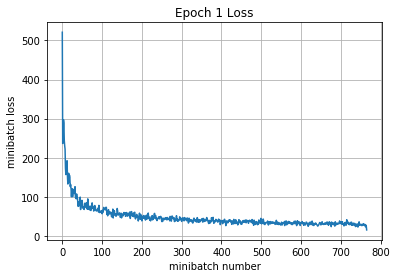

Validation
Epoch 1, Overall loss = 0.425 and accuracy of 0.38


In [7]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [4]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):
    # (1) Conv -> BN -> ReLU -> Max Pool
    W1conv = tf.get_variable("W1conv", shape=[7, 7, 3, 32])
    b1conv = tf.get_variable("b1conv", shape=[32])
    # Conv layer (32 filters of size 7x7, S = 1)
    # Output shape (N, 26, 26, 32) because (32-7+1) / 1 = 26
    h1_conv = tf.nn.conv2d(X, W1conv, strides=[1,1,1,1], padding='VALID') + b1conv        
    # Spatial batchnorm (trainable parameters, with scale and centering)
    h1_bn = tf.layers.batch_normalization(h1_conv, training=is_training)    
    # ReLU layer (should be AFTER batchnorm, IMO)
    h1_relu = tf.nn.relu(h1_bn)    
    # Max Pooling (2x2, S = 2), output is 13x13x32 because (26-2+1) / 2 = 13
    #                                        N H W C            N H W C
    h1_pool = tf.nn.max_pool(h1_relu, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # (2) FC -> ReLU
    W2 = tf.get_variable("W2", shape=[5408, 1024])  # After max pooling: 13*13*32 = 5408
    b2 = tf.get_variable("b2", shape=[1024])
    h1_pool_flat = tf.reshape(h1_pool, [-1, 5408])
    # Affine (fully connected) layer (1024 output units)
    h2_fc = tf.matmul(h1_pool_flat, W2) + b2
    # ReLU layer
    h2_relu = tf.nn.relu(h2_fc) 
    
    # (3) FC (out)
    W3 = tf.get_variable("W3", shape=[1024, 10])
    b3 = tf.get_variable("b3", shape=[10])
    # Affine layer (1024 input units -> 10 output units)
    out = h3_fc = tf.matmul(h2_relu, W3) + b3
    
    return out

y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [5]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

110 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [6]:
try:
    with tf.Session() as sess:
        with tf.device("/cpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

109 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [11]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!

total_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

optimizer = tf.train.RMSPropOptimizer(1e-3)

In [12]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [13]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 2.53 and accuracy of 0.16
Iteration 100: with minibatch training loss = 2.53 and accuracy of 0.23
Iteration 200: with minibatch training loss = 1.79 and accuracy of 0.41
Iteration 300: with minibatch training loss = 1.55 and accuracy of 0.41
Iteration 400: with minibatch training loss = 1.56 and accuracy of 0.55
Iteration 500: with minibatch training loss = 1.2 and accuracy of 0.55
Iteration 600: with minibatch training loss = 1.52 and accuracy of 0.38
Iteration 700: with minibatch training loss = 1.37 and accuracy of 0.5
Epoch 1, Overall loss = 1.67 and accuracy of 0.413


(1.6733511978850073, 0.41283673469387755)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [14]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.33 and accuracy of 0.526


(1.3326266331672669, 0.52600000000000002)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [3]:
# Hyperparameters generation function

def hyperparameters(gen_fns, fn_args, num):
    """Hyperparameter generator.
    
    Args:
        gen_fns: Generator functions
        fn_args: Arguments of gen_fns
        num: Number of iterations
    
    Returns:
        Tuple of hyperparameters
    """
    
    for _ in range(num):
        yield tuple(fn(*params) for (fn, params) in zip(gen_fns, fn_args))

In [4]:
# Modifying model running function

def run_my_model(session, predict, loss_val,
                 Xd, yd, Xv=None, yv=None,
                 epochs=1, batch_size=64, print_every=100,
                 plot_losses=False, val_every_epoch=False, training=None,
                 lr=1e-3, reg=1e-4, lr_dec=1, dpo=0):
    
    # Cast hyperparameters to the correct type
    #learning_rate = tf.cast(learning_rate, tf.float32)
    #reg_strength = tf.cast(reg_strength, tf.float32)
    
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(y_out, 1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(len(Xd))
    np.random.shuffle(train_indicies)
    
    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss_val, correct_prediction, accuracy]
    if training_now:
        variables[-1] = training
    
    # Storing training/validation loss and accuracy every epoch
    train_hist = {'loss': [], 'acc': []}
    if val_every_epoch:
        val_hist = {'loss': [], 'acc': []}
    else:
        val_hist = None
    
    # counter    
    for e in range(epochs):
        print("Epoch {}/{} (learning rate {:.3e})".format(e+1, epochs, lr))
        # keep track of losses and accuracy
        correct = []
        losses = []
        
        # make sure we iterate over the dataset once
        num_batches = int(math.ceil(len(Xd) / batch_size))
        for i in range(num_batches):
            # generate indicies for the batch
            start_idx = (i*batch_size) % len(Xd)
            idxs = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idxs, ...],
                         y: yd[idxs],
                         is_training: training_now,
                         learning_rate: lr,
                         reg_strength: reg,
                         dropout_rate: dpo}
            # get batch size
            actual_batch_size = len(yd[idxs])
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss)#*actual_batch_size)
            correct.append(np.sum(corr))
            
            # print every now and then
            if training_now and (i % print_every) == 0:
                print("Iteration {:>3}:  minibatch training loss = {:.3f}, accuracy = {:.3f}"\
                      .format(i, loss, np.sum(corr) / actual_batch_size))
            
        total_correct = np.sum(correct) / len(Xd)
        total_loss    = np.sum(losses) / num_batches
        
        train_hist['loss'].append(total_loss)
        train_hist['acc'].append(total_correct)
        
        print("Loss: {:.3f} | Accuracy: {:.3f} (training, average)"\
              .format(total_loss, total_correct))
        
        if plot_losses:
            plt.plot(np.array(losses))
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
            
        if val_every_epoch:
            val_variables = [loss_val, correct_prediction, accuracy]
            val_feed_dict = {X: Xv,
                            y: yv,
                            is_training: False,
                            learning_rate: lr,
                            reg_strength: reg,
                            dropout_rate: dpo}
            val_loss, val_corr, val_acc = session.run(val_variables, feed_dict=val_feed_dict)
            val_hist['loss'].append(val_loss)
            val_hist['acc'].append(val_acc)
            print("Loss: {:.3f} | Accuracy: {:.3f} (validation)\n"\
                  .format(val_loss, val_acc))
        
        # learning rate decay every epoch
        lr *= lr_dec
        
            
    return train_hist, val_hist

In [5]:
# Feel free to play with this cell

def my_model(X, y, is_training, reg_strength=1e-4, dropout_rate=0):
    '''My model with the following architecture:
    1. Conv (5x5x32, S=1) - BN - ReLU - Dropout
    2. Conv (3x3x64, S=1) - BN - ReLU - Dropout
    3. Pool (2x2, S=2)
    4. Conv (3x3x128, S=2) - BN - ReLU
    5. AvgPool (7x7, S=1)
    6. Affine (10)
    '''
        
    regularizer = tf.contrib.layers.l2_regularizer(reg_strength)
    keep_prob = 1 - dropout_rate
    
    # (1) Conv (7x7x32, S=2) - BN - ReLU | Output shape (N, 28, 28, 32)
    h1_conv = tf.layers.conv2d(inputs=X, filters=32, padding='VALID', kernel_size=5, strides=1,
                               activation=None, kernel_regularizer=regularizer)
    h1_bn   = tf.layers.batch_normalization(inputs=h1_conv, training=is_training)
    h1_relu = tf.nn.relu(h1_bn)
    h1      = tf.nn.dropout(h1_relu, keep_prob)
    print("h1 shape: ", h1.shape)
    
    # (2) Conv (3x3x64, S=1) - BN - ReLU | Output shape (N, 28, 28, 64)
    h2_conv = tf.layers.conv2d(inputs=h1, filters=64, padding='SAME', kernel_size=3, strides=1,
                               activation=None, kernel_regularizer=regularizer)
    h2_bn   = tf.layers.batch_normalization(inputs=h2_conv, training=is_training)
    h2_relu = tf.nn.relu(h2_bn)
    h2      = tf.nn.dropout(h2_relu, keep_prob)
    print("h2 shape: ", h2.shape)
    
    # (3) Pool (2x2, S=2) | Output shape (N, 14, 14, 64)
    h3 = tf.layers.max_pooling2d(inputs=h2, pool_size=2, strides=2, padding='VALID')
    print("h3 shape: ", h3.shape)
    
    # (4) Conv (3x3x128, S=2) - BN - ReLU | Output shape (N, 7, 7, 128)
    h4_conv = tf.layers.conv2d(inputs=h3, filters=128, padding='SAME', kernel_size=3, strides=2,
                               activation=None, kernel_regularizer=regularizer)
    h4_bn   = tf.layers.batch_normalization(inputs=h4_conv, training=is_training)
    h4      = tf.nn.relu(h4_bn)
    print("h4 shape: ", h4.shape)
    
    # (5) AvgPool (7x7, S=1) | Output shape (N, 1, 1, 128)
    h5 = tf.layers.average_pooling2d(inputs=h4, pool_size=7, strides=1, padding='VALID')
    h5_flat = tf.reshape(h5, [-1, 128])
    print("h5 shape: ", h5.shape, " flattened: ", h5_flat.shape)
    
    
    # (6) Affine layer (hidden size 10)
    out = tf.layers.dense(inputs=h5_flat, units=10, activation=None)
    print("out shape: ", out.shape)
    
    return out
    

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
# Hyperparameters
learning_rate = tf.placeholder(tf.float32, shape=())
reg_strength = tf.placeholder(tf.float32, shape=())
dropout_rate = tf.placeholder(tf.float32, shape=())

y_out = my_model(X, y, is_training, reg_strength, dropout_rate)
mean_loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y,10), logits=y_out)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

h1 shape:  (?, 28, 28, 32)
h2 shape:  (?, 28, 28, 64)
h3 shape:  (?, 14, 14, 64)
h4 shape:  (?, 7, 7, 128)
h5 shape:  (?, 1, 1, 128)  flattened:  (?, 128)
out shape:  (?, 10)


### Whoever is reading this, [beware](#Ooops!)!

In the following code, the session (and therefores the model) is shared between the all hyperparameters iterations.
Thus the same model is trained all over again, just changing the hyperparameters every now and then.
The result is therefore **WRONG**! I'm not running it again since it takes about 15 hours to complete...

In [31]:
# First hyperparameter search (!!! MASSIVE time, left overnight)

# Smaller random subset for faster training
idxs = np.random.randint(0, len(X_train), len(X_train) // 5)
X_train_small = X_train[idxs, ...]
y_train_small = y_train[idxs, ...]

print("Random subset size:")
print("X_train:", X_train_small.shape)
print("y_train:", y_train_small.shape)
print("")

# Coarse search ranges for hyperparameters
learn_rates   = np.logspace(-4, -1, 4)  # 10^(-4 to -1)
reg_strengths = np.logspace(-5, -1, 5)  # 10^(-5 to -1)
lr_decays     = [1, 0.96]
dropout_rates = [0, 0.50]

num_combs = len(learn_rates) * len(reg_strengths) * len(lr_decays) * len(dropout_rates)

import itertools
from time import time


with tf.Session() as sess: # This should in the hyperparameter loop!
    sess.run(tf.global_variables_initializer())
    
    train_hists = {}
    val_hists = {}
    best_acc = 0.0
    best_hyps = ()
    
    print('Training\n')
    # Iterate through all hyperparameters combinations (This should be the top-level loop!)
    for i, (lr, reg, lr_dec, dpo) in enumerate(itertools.product(learn_rates, reg_strengths, lr_decays, dropout_rates)):
        t0 = time()
        print('-' * 80)
        print("Hyperparameters {}/{}: lr = {:.2e} | reg = {:.2e} | lr_dec = {:.3f} | dpo = {:.3f}"\
              .format(i+1, num_combs, lr, reg, lr_dec, dpo))
        print('-' * 80)
        train_hist, val_hist = run_my_model(sess, y_out, mean_loss,
                                            X_train_small, y_train_small, X_val, y_val,
                                            epochs=5, batch_size=64, print_every=50,
                                            plot_losses=False, val_every_epoch=True, training=train_step,
                                            lr=lr, reg=reg, lr_dec=lr_dec, dpo=dpo)
        train_hists[(lr, reg, lr_dec, dpo)] = train_hist
        if val_hist:
            val_hists[(lr, reg, lr_dec, dpo)] = val_hist
            if val_hist['acc'][-1] > best_acc:
                best_hyps = (lr, reg, lr_dec, dpo)
                best_acc = val_hist['acc'][-1]        
        t1 = time()
        print("Done in {:.0f}s.\n".format(t1 - t0))
    
    if best_hyps:
        print("\nBest hyperparameters: lr = {:.2e}, reg = {:.2e}, lr_dec = {:.3f}, dpo = {:.3f}"\
              .format(best_hyps[0], best_hyps[1], best_hyps[2], best_hyps[3]))
        print("with validation accuracy {:.3g}".format(best_acc))

Random subset size:
X_train: (9800, 32, 32, 3)
y_train: (9800,)

Training

--------------------------------------------------------------------------------
Hyperparameters 1/80: lr = 1.00e-04 | reg = 1.00e-05 | lr_dec = 1.000 | dpo = 0.000
--------------------------------------------------------------------------------
Epoch 1/5 (learning rate 1.000e-04)
Iteration   0:  minibatch training loss = 2.531, accuracy = 0.094
Iteration  50:  minibatch training loss = 1.944, accuracy = 0.344
Iteration 100:  minibatch training loss = 2.013, accuracy = 0.297
Iteration 150:  minibatch training loss = 1.964, accuracy = 0.328
Loss: 2.031 | Accuracy: 0.270 (training, average)
Loss: 1.929 | Accuracy: 0.337 (validation)

Epoch 2/5 (learning rate 1.000e-04)
Iteration   0:  minibatch training loss = 1.850, accuracy = 0.328
Iteration  50:  minibatch training loss = 1.662, accuracy = 0.453
Iteration 100:  minibatch training loss = 1.814, accuracy = 0.391
Iteration 150:  minibatch training loss = 1.831, ac

Iteration   0:  minibatch training loss = 1.485, accuracy = 0.469
Iteration  50:  minibatch training loss = 1.506, accuracy = 0.422
Iteration 100:  minibatch training loss = 1.460, accuracy = 0.469
Iteration 150:  minibatch training loss = 1.371, accuracy = 0.500
Loss: 1.419 | Accuracy: 0.502 (training, average)
Loss: 1.434 | Accuracy: 0.494 (validation)

Epoch 5/5 (learning rate 8.493e-05)
Iteration   0:  minibatch training loss = 1.364, accuracy = 0.500
Iteration  50:  minibatch training loss = 1.445, accuracy = 0.484
Iteration 100:  minibatch training loss = 1.466, accuracy = 0.453
Iteration 150:  minibatch training loss = 1.354, accuracy = 0.484
Loss: 1.408 | Accuracy: 0.506 (training, average)
Loss: 1.424 | Accuracy: 0.497 (validation)

Done in 670s.

--------------------------------------------------------------------------------
Hyperparameters 5/80: lr = 1.00e-04 | reg = 1.00e-04 | lr_dec = 1.000 | dpo = 0.000
--------------------------------------------------------------------

Iteration  50:  minibatch training loss = 1.130, accuracy = 0.562
Iteration 100:  minibatch training loss = 1.272, accuracy = 0.516
Iteration 150:  minibatch training loss = 1.254, accuracy = 0.594
Loss: 1.291 | Accuracy: 0.558 (training, average)
Loss: 1.338 | Accuracy: 0.534 (validation)

Epoch 3/5 (learning rate 9.216e-05)
Iteration   0:  minibatch training loss = 1.429, accuracy = 0.422
Iteration  50:  minibatch training loss = 1.109, accuracy = 0.547
Iteration 100:  minibatch training loss = 1.248, accuracy = 0.484
Iteration 150:  minibatch training loss = 1.184, accuracy = 0.562
Loss: 1.283 | Accuracy: 0.551 (training, average)
Loss: 1.315 | Accuracy: 0.547 (validation)

Epoch 4/5 (learning rate 8.847e-05)
Iteration   0:  minibatch training loss = 1.352, accuracy = 0.469
Iteration  50:  minibatch training loss = 1.097, accuracy = 0.625
Iteration 100:  minibatch training loss = 1.223, accuracy = 0.531
Iteration 150:  minibatch training loss = 1.188, accuracy = 0.578
Loss: 1.264 | 

Iteration   0:  minibatch training loss = 1.420, accuracy = 0.500
Iteration  50:  minibatch training loss = 1.461, accuracy = 0.391
Iteration 100:  minibatch training loss = 1.185, accuracy = 0.547
Iteration 150:  minibatch training loss = 1.141, accuracy = 0.547
Loss: 1.221 | Accuracy: 0.582 (training, average)
Loss: 1.301 | Accuracy: 0.549 (validation)

Epoch 2/5 (learning rate 9.600e-05)
Iteration   0:  minibatch training loss = 1.486, accuracy = 0.422
Iteration  50:  minibatch training loss = 1.344, accuracy = 0.469
Iteration 100:  minibatch training loss = 1.189, accuracy = 0.531
Iteration 150:  minibatch training loss = 1.150, accuracy = 0.531
Loss: 1.209 | Accuracy: 0.582 (training, average)
Loss: 1.294 | Accuracy: 0.554 (validation)

Epoch 3/5 (learning rate 9.216e-05)
Iteration   0:  minibatch training loss = 1.383, accuracy = 0.422
Iteration  50:  minibatch training loss = 1.381, accuracy = 0.422
Iteration 100:  minibatch training loss = 1.218, accuracy = 0.500
Iteration 150:

Iteration   0:  minibatch training loss = 0.873, accuracy = 0.688
Iteration  50:  minibatch training loss = 0.705, accuracy = 0.734
Iteration 100:  minibatch training loss = 0.915, accuracy = 0.625
Iteration 150:  minibatch training loss = 1.030, accuracy = 0.594
Loss: 0.904 | Accuracy: 0.695 (training, average)
Loss: 1.144 | Accuracy: 0.611 (validation)

Done in 666s.

--------------------------------------------------------------------------------
Hyperparameters 16/80: lr = 1.00e-04 | reg = 1.00e-02 | lr_dec = 0.960 | dpo = 0.500
--------------------------------------------------------------------------------
Epoch 1/5 (learning rate 1.000e-04)
Iteration   0:  minibatch training loss = 1.320, accuracy = 0.422
Iteration  50:  minibatch training loss = 1.229, accuracy = 0.641
Iteration 100:  minibatch training loss = 1.187, accuracy = 0.609
Iteration 150:  minibatch training loss = 1.120, accuracy = 0.609
Loss: 1.160 | Accuracy: 0.598 (training, average)
Loss: 1.274 | Accuracy: 0.556 

Iteration  50:  minibatch training loss = 0.896, accuracy = 0.703
Iteration 100:  minibatch training loss = 0.781, accuracy = 0.719
Iteration 150:  minibatch training loss = 0.581, accuracy = 0.812
Loss: 0.847 | Accuracy: 0.719 (training, average)
Loss: 1.085 | Accuracy: 0.625 (validation)

Epoch 4/5 (learning rate 8.847e-05)
Iteration   0:  minibatch training loss = 0.871, accuracy = 0.719
Iteration  50:  minibatch training loss = 0.886, accuracy = 0.703
Iteration 100:  minibatch training loss = 0.772, accuracy = 0.719
Iteration 150:  minibatch training loss = 0.577, accuracy = 0.828
Loss: 0.837 | Accuracy: 0.723 (training, average)
Loss: 1.078 | Accuracy: 0.633 (validation)

Epoch 5/5 (learning rate 8.493e-05)
Iteration   0:  minibatch training loss = 0.860, accuracy = 0.734
Iteration  50:  minibatch training loss = 0.878, accuracy = 0.703
Iteration 100:  minibatch training loss = 0.764, accuracy = 0.734
Iteration 150:  minibatch training loss = 0.572, accuracy = 0.828
Loss: 0.828 | 

Iteration 100:  minibatch training loss = 0.736, accuracy = 0.750
Iteration 150:  minibatch training loss = 0.985, accuracy = 0.562
Loss: 0.872 | Accuracy: 0.697 (training, average)
Loss: 1.668 | Accuracy: 0.451 (validation)

Epoch 2/5 (learning rate 9.600e-04)
Iteration   0:  minibatch training loss = 0.990, accuracy = 0.625
Iteration  50:  minibatch training loss = 0.706, accuracy = 0.750
Iteration 100:  minibatch training loss = 0.665, accuracy = 0.781
Iteration 150:  minibatch training loss = 0.917, accuracy = 0.625
Loss: 0.826 | Accuracy: 0.713 (training, average)
Loss: 1.425 | Accuracy: 0.523 (validation)

Epoch 3/5 (learning rate 9.216e-04)
Iteration   0:  minibatch training loss = 0.929, accuracy = 0.672
Iteration  50:  minibatch training loss = 0.698, accuracy = 0.719
Iteration 100:  minibatch training loss = 0.632, accuracy = 0.812
Iteration 150:  minibatch training loss = 0.856, accuracy = 0.641
Loss: 0.782 | Accuracy: 0.730 (training, average)
Loss: 1.455 | Accuracy: 0.524 

Iteration  50:  minibatch training loss = 1.076, accuracy = 0.516
Iteration 100:  minibatch training loss = 0.825, accuracy = 0.734
Iteration 150:  minibatch training loss = 0.965, accuracy = 0.672
Loss: 0.894 | Accuracy: 0.688 (training, average)
Loss: 1.226 | Accuracy: 0.551 (validation)

Done in 668s.

--------------------------------------------------------------------------------
Hyperparameters 27/80: lr = 1.00e-03 | reg = 1.00e-04 | lr_dec = 0.960 | dpo = 0.000
--------------------------------------------------------------------------------
Epoch 1/5 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 0.855, accuracy = 0.641
Iteration  50:  minibatch training loss = 0.856, accuracy = 0.734
Iteration 100:  minibatch training loss = 0.719, accuracy = 0.781
Iteration 150:  minibatch training loss = 0.776, accuracy = 0.703
Loss: 0.657 | Accuracy: 0.780 (training, average)
Loss: 1.369 | Accuracy: 0.557 (validation)

Epoch 2/5 (learning rate 9.600e-04)
Iteration   0:  

Iteration 100:  minibatch training loss = 0.649, accuracy = 0.797
Iteration 150:  minibatch training loss = 0.736, accuracy = 0.766
Loss: 0.811 | Accuracy: 0.712 (training, average)
Loss: 1.206 | Accuracy: 0.613 (validation)

Epoch 4/5 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 0.761, accuracy = 0.734
Iteration  50:  minibatch training loss = 0.953, accuracy = 0.656
Iteration 100:  minibatch training loss = 0.716, accuracy = 0.781
Iteration 150:  minibatch training loss = 0.787, accuracy = 0.750
Loss: 0.795 | Accuracy: 0.718 (training, average)
Loss: 1.244 | Accuracy: 0.582 (validation)

Epoch 5/5 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 0.771, accuracy = 0.750
Iteration  50:  minibatch training loss = 0.706, accuracy = 0.781
Iteration 100:  minibatch training loss = 0.731, accuracy = 0.828
Iteration 150:  minibatch training loss = 0.775, accuracy = 0.719
Loss: 0.786 | Accuracy: 0.729 (training, average)
Loss: 1.232 | Accuracy: 0.587 

Iteration 150:  minibatch training loss = 0.896, accuracy = 0.641
Loss: 0.838 | Accuracy: 0.699 (training, average)
Loss: 1.562 | Accuracy: 0.529 (validation)

Epoch 2/5 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 0.564, accuracy = 0.797
Iteration  50:  minibatch training loss = 0.933, accuracy = 0.672
Iteration 100:  minibatch training loss = 0.729, accuracy = 0.750
Iteration 150:  minibatch training loss = 0.775, accuracy = 0.734
Loss: 0.775 | Accuracy: 0.722 (training, average)
Loss: 1.288 | Accuracy: 0.568 (validation)

Epoch 3/5 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 0.500, accuracy = 0.844
Iteration  50:  minibatch training loss = 0.749, accuracy = 0.750
Iteration 100:  minibatch training loss = 0.734, accuracy = 0.719
Iteration 150:  minibatch training loss = 0.690, accuracy = 0.734
Loss: 0.743 | Accuracy: 0.738 (training, average)
Loss: 1.329 | Accuracy: 0.572 (validation)

Epoch 4/5 (learning rate 1.000e-03)
Iteration   0:  

Iteration 100:  minibatch training loss = 0.199, accuracy = 0.969
Iteration 150:  minibatch training loss = 0.234, accuracy = 0.953
Loss: 0.209 | Accuracy: 0.961 (training, average)
Loss: 1.072 | Accuracy: 0.655 (validation)

Done in 664s.

--------------------------------------------------------------------------------
Hyperparameters 38/80: lr = 1.00e-03 | reg = 1.00e-01 | lr_dec = 1.000 | dpo = 0.500
--------------------------------------------------------------------------------
Epoch 1/5 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 0.684, accuracy = 0.688
Iteration  50:  minibatch training loss = 0.936, accuracy = 0.703
Iteration 100:  minibatch training loss = 0.709, accuracy = 0.797
Iteration 150:  minibatch training loss = 0.862, accuracy = 0.688
Loss: 0.768 | Accuracy: 0.723 (training, average)
Loss: 1.433 | Accuracy: 0.577 (validation)

Epoch 2/5 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 0.737, accuracy = 0.734
Iteration  50:  

Iteration 150:  minibatch training loss = 0.667, accuracy = 0.750
Loss: 0.709 | Accuracy: 0.750 (training, average)
Loss: 2.392 | Accuracy: 0.358 (validation)

Epoch 4/5 (learning rate 1.000e-02)
Iteration   0:  minibatch training loss = 0.599, accuracy = 0.828
Iteration  50:  minibatch training loss = 0.753, accuracy = 0.734
Iteration 100:  minibatch training loss = 0.567, accuracy = 0.797
Iteration 150:  minibatch training loss = 0.668, accuracy = 0.734
Loss: 0.593 | Accuracy: 0.797 (training, average)
Loss: 2.548 | Accuracy: 0.347 (validation)

Epoch 5/5 (learning rate 1.000e-02)
Iteration   0:  minibatch training loss = 0.494, accuracy = 0.844
Iteration  50:  minibatch training loss = 0.630, accuracy = 0.766
Iteration 100:  minibatch training loss = 0.418, accuracy = 0.875
Iteration 150:  minibatch training loss = 0.563, accuracy = 0.828
Loss: 0.529 | Accuracy: 0.819 (training, average)
Loss: 2.720 | Accuracy: 0.386 (validation)

Done in 661s.

-------------------------------------

Loss: 0.425 | Accuracy: 0.859 (training, average)
Loss: 1.198 | Accuracy: 0.613 (validation)

Epoch 2/5 (learning rate 1.000e-02)
Iteration   0:  minibatch training loss = 0.442, accuracy = 0.859
Iteration  50:  minibatch training loss = 0.249, accuracy = 0.922
Iteration 100:  minibatch training loss = 0.373, accuracy = 0.859
Iteration 150:  minibatch training loss = 0.429, accuracy = 0.906
Loss: 0.322 | Accuracy: 0.904 (training, average)
Loss: 1.286 | Accuracy: 0.605 (validation)

Epoch 3/5 (learning rate 1.000e-02)
Iteration   0:  minibatch training loss = 0.323, accuracy = 0.891
Iteration  50:  minibatch training loss = 0.171, accuracy = 0.984
Iteration 100:  minibatch training loss = 0.328, accuracy = 0.922
Iteration 150:  minibatch training loss = 0.378, accuracy = 0.875
Loss: 0.248 | Accuracy: 0.936 (training, average)
Loss: 1.420 | Accuracy: 0.587 (validation)

Epoch 4/5 (learning rate 1.000e-02)
Iteration   0:  minibatch training loss = 0.251, accuracy = 0.938
Iteration  50:  

Iteration 150:  minibatch training loss = 0.744, accuracy = 0.688
Loss: 0.593 | Accuracy: 0.786 (training, average)
Loss: 1.307 | Accuracy: 0.627 (validation)

Done in 668s.

--------------------------------------------------------------------------------
Hyperparameters 49/80: lr = 1.00e-02 | reg = 1.00e-03 | lr_dec = 1.000 | dpo = 0.000
--------------------------------------------------------------------------------
Epoch 1/5 (learning rate 1.000e-02)
Iteration   0:  minibatch training loss = 0.249, accuracy = 0.906
Iteration  50:  minibatch training loss = 0.387, accuracy = 0.875
Iteration 100:  minibatch training loss = 0.204, accuracy = 0.969
Iteration 150:  minibatch training loss = 0.232, accuracy = 0.891
Loss: 0.258 | Accuracy: 0.920 (training, average)
Loss: 1.381 | Accuracy: 0.603 (validation)

Epoch 2/5 (learning rate 1.000e-02)
Iteration   0:  minibatch training loss = 0.171, accuracy = 0.969
Iteration  50:  minibatch training loss = 0.225, accuracy = 0.922
Iteration 100:  

Loss: 0.557 | Accuracy: 0.797 (training, average)
Loss: 1.416 | Accuracy: 0.617 (validation)

Epoch 4/5 (learning rate 8.847e-03)
Iteration   0:  minibatch training loss = 0.551, accuracy = 0.828
Iteration  50:  minibatch training loss = 0.625, accuracy = 0.734
Iteration 100:  minibatch training loss = 0.600, accuracy = 0.781
Iteration 150:  minibatch training loss = 0.447, accuracy = 0.812
Loss: 0.511 | Accuracy: 0.820 (training, average)
Loss: 1.235 | Accuracy: 0.644 (validation)

Epoch 5/5 (learning rate 8.493e-03)
Iteration   0:  minibatch training loss = 0.598, accuracy = 0.797
Iteration  50:  minibatch training loss = 0.531, accuracy = 0.875
Iteration 100:  minibatch training loss = 0.392, accuracy = 0.844
Iteration 150:  minibatch training loss = 0.460, accuracy = 0.875
Loss: 0.482 | Accuracy: 0.831 (training, average)
Loss: 1.463 | Accuracy: 0.591 (validation)

Done in 667s.

--------------------------------------------------------------------------------
Hyperparameters 53/80:

Iteration   0:  minibatch training loss = 0.642, accuracy = 0.797
Iteration  50:  minibatch training loss = 0.729, accuracy = 0.734
Iteration 100:  minibatch training loss = 0.510, accuracy = 0.828
Iteration 150:  minibatch training loss = 0.733, accuracy = 0.750
Loss: 0.593 | Accuracy: 0.784 (training, average)
Loss: 1.394 | Accuracy: 0.621 (validation)

Epoch 3/5 (learning rate 9.216e-03)
Iteration   0:  minibatch training loss = 0.514, accuracy = 0.828
Iteration  50:  minibatch training loss = 0.467, accuracy = 0.844
Iteration 100:  minibatch training loss = 0.452, accuracy = 0.828
Iteration 150:  minibatch training loss = 0.716, accuracy = 0.734
Loss: 0.496 | Accuracy: 0.818 (training, average)
Loss: 1.277 | Accuracy: 0.634 (validation)

Epoch 4/5 (learning rate 8.847e-03)
Iteration   0:  minibatch training loss = 0.448, accuracy = 0.828
Iteration  50:  minibatch training loss = 0.392, accuracy = 0.844
Iteration 100:  minibatch training loss = 0.607, accuracy = 0.766
Iteration 150:

Iteration   0:  minibatch training loss = 0.291, accuracy = 0.875
Iteration  50:  minibatch training loss = 0.405, accuracy = 0.875
Iteration 100:  minibatch training loss = 0.714, accuracy = 0.766
Iteration 150:  minibatch training loss = 0.368, accuracy = 0.875
Loss: 0.557 | Accuracy: 0.809 (training, average)
Loss: 1.891 | Accuracy: 0.571 (validation)

Epoch 2/5 (learning rate 9.600e-03)
Iteration   0:  minibatch training loss = 0.512, accuracy = 0.812
Iteration  50:  minibatch training loss = 0.357, accuracy = 0.844
Iteration 100:  minibatch training loss = 0.470, accuracy = 0.844
Iteration 150:  minibatch training loss = 0.453, accuracy = 0.891
Loss: 0.529 | Accuracy: 0.819 (training, average)
Loss: 1.494 | Accuracy: 0.609 (validation)

Epoch 3/5 (learning rate 9.216e-03)
Iteration   0:  minibatch training loss = 0.380, accuracy = 0.828
Iteration  50:  minibatch training loss = 0.279, accuracy = 0.859
Iteration 100:  minibatch training loss = 0.314, accuracy = 0.891
Iteration 150:

Iteration   0:  minibatch training loss = 0.610, accuracy = 0.781
Iteration  50:  minibatch training loss = 0.203, accuracy = 0.938
Iteration 100:  minibatch training loss = 0.430, accuracy = 0.875
Iteration 150:  minibatch training loss = 0.491, accuracy = 0.812
Loss: 0.356 | Accuracy: 0.872 (training, average)
Loss: 2.835 | Accuracy: 0.478 (validation)

Done in 686s.

--------------------------------------------------------------------------------
Hyperparameters 64/80: lr = 1.00e-01 | reg = 1.00e-05 | lr_dec = 0.960 | dpo = 0.500
--------------------------------------------------------------------------------
Epoch 1/5 (learning rate 1.000e-01)
Iteration   0:  minibatch training loss = 1.242, accuracy = 0.641
Iteration  50:  minibatch training loss = 0.947, accuracy = 0.703
Iteration 100:  minibatch training loss = 0.912, accuracy = 0.734
Iteration 150:  minibatch training loss = 0.971, accuracy = 0.734
Loss: 1.021 | Accuracy: 0.653 (training, average)
Loss: 1.658 | Accuracy: 0.548 

Iteration  50:  minibatch training loss = 0.085, accuracy = 0.953
Iteration 100:  minibatch training loss = 0.129, accuracy = 0.938
Iteration 150:  minibatch training loss = 0.188, accuracy = 0.922
Loss: 0.151 | Accuracy: 0.947 (training, average)
Loss: 1.882 | Accuracy: 0.599 (validation)

Epoch 4/5 (learning rate 8.847e-02)
Iteration   0:  minibatch training loss = 0.222, accuracy = 0.906
Iteration  50:  minibatch training loss = 0.146, accuracy = 0.938
Iteration 100:  minibatch training loss = 0.185, accuracy = 0.922
Iteration 150:  minibatch training loss = 0.129, accuracy = 0.953
Loss: 0.133 | Accuracy: 0.953 (training, average)
Loss: 1.906 | Accuracy: 0.639 (validation)

Epoch 5/5 (learning rate 8.493e-02)
Iteration   0:  minibatch training loss = 0.094, accuracy = 0.953
Iteration  50:  minibatch training loss = 0.115, accuracy = 0.953
Iteration 100:  minibatch training loss = 0.292, accuracy = 0.906
Iteration 150:  minibatch training loss = 0.079, accuracy = 0.984
Loss: 0.123 | 

Iteration 100:  minibatch training loss = 0.168, accuracy = 0.953
Iteration 150:  minibatch training loss = 0.149, accuracy = 0.969
Loss: 0.221 | Accuracy: 0.924 (training, average)
Loss: 1.473 | Accuracy: 0.638 (validation)

Epoch 2/5 (learning rate 9.600e-02)
Iteration   0:  minibatch training loss = 0.175, accuracy = 0.953
Iteration  50:  minibatch training loss = 0.245, accuracy = 0.906
Iteration 100:  minibatch training loss = 0.086, accuracy = 0.984
Iteration 150:  minibatch training loss = 0.144, accuracy = 0.938
Loss: 0.138 | Accuracy: 0.952 (training, average)
Loss: 1.609 | Accuracy: 0.648 (validation)

Epoch 3/5 (learning rate 9.216e-02)
Iteration   0:  minibatch training loss = 0.066, accuracy = 0.984
Iteration  50:  minibatch training loss = 0.040, accuracy = 0.984
Iteration 100:  minibatch training loss = 0.126, accuracy = 0.969
Iteration 150:  minibatch training loss = 0.178, accuracy = 0.953
Loss: 0.083 | Accuracy: 0.971 (training, average)
Loss: 1.968 | Accuracy: 0.633 

Iteration  50:  minibatch training loss = 0.315, accuracy = 0.906
Iteration 100:  minibatch training loss = 0.716, accuracy = 0.781
Iteration 150:  minibatch training loss = 0.516, accuracy = 0.812
Loss: 0.656 | Accuracy: 0.772 (training, average)
Loss: 1.689 | Accuracy: 0.569 (validation)

Done in 666s.

--------------------------------------------------------------------------------
Hyperparameters 75/80: lr = 1.00e-01 | reg = 1.00e-02 | lr_dec = 0.960 | dpo = 0.000
--------------------------------------------------------------------------------
Epoch 1/5 (learning rate 1.000e-01)
Iteration   0:  minibatch training loss = 0.269, accuracy = 0.891
Iteration  50:  minibatch training loss = 0.219, accuracy = 0.906
Iteration 100:  minibatch training loss = 0.133, accuracy = 0.938
Iteration 150:  minibatch training loss = 0.205, accuracy = 0.922
Loss: 0.171 | Accuracy: 0.939 (training, average)
Loss: 1.348 | Accuracy: 0.640 (validation)

Epoch 2/5 (learning rate 9.600e-02)
Iteration   0:  

Iteration 100:  minibatch training loss = 0.815, accuracy = 0.750
Iteration 150:  minibatch training loss = 0.635, accuracy = 0.719
Loss: 0.637 | Accuracy: 0.778 (training, average)
Loss: 1.908 | Accuracy: 0.553 (validation)

Epoch 4/5 (learning rate 1.000e-01)
Iteration   0:  minibatch training loss = 0.615, accuracy = 0.797
Iteration  50:  minibatch training loss = 0.650, accuracy = 0.750
Iteration 100:  minibatch training loss = 0.957, accuracy = 0.734
Iteration 150:  minibatch training loss = 0.613, accuracy = 0.766
Loss: 0.649 | Accuracy: 0.781 (training, average)
Loss: 1.786 | Accuracy: 0.582 (validation)

Epoch 5/5 (learning rate 1.000e-01)
Iteration   0:  minibatch training loss = 0.436, accuracy = 0.844
Iteration  50:  minibatch training loss = 0.622, accuracy = 0.766
Iteration 100:  minibatch training loss = 0.688, accuracy = 0.781
Iteration 150:  minibatch training loss = 0.492, accuracy = 0.797
Loss: 0.623 | Accuracy: 0.785 (training, average)
Loss: 1.691 | Accuracy: 0.593 

### Coarse Hyperparameter Search Results (It's all wrong! See [Ooops!](#Ooops!))

It took almost **15 hours** on my i5 dual-core, whew.
The output is saved to **TF_hyp_coarse_search.txt**

Best hyperparameters: lr = 1.00e-02, reg = 1.00e-01, lr_dec = 1.000, dpo = 0.000 with validation accuracy: **0.714**.

There is some **overfitting** (train acc = 0.9 vs val acc = 0.7).
**Dropout helps** that but the effect would be visible in more epochs (see Droput.ipynb). The overfitting might be also caused by training on **1/5 subset** while validating on the whole validation set.

**Regularization strength** 0.1 seems to be the best for all cases.
**Learning rate** 0.01 might be too high since training accuracy 0.9 in just 5 epochs is a bit too high.
**Learning rate decay** makes things to converge faster but that increases the overfitting.
In conjunction with dropout it seems to always improve the performance.

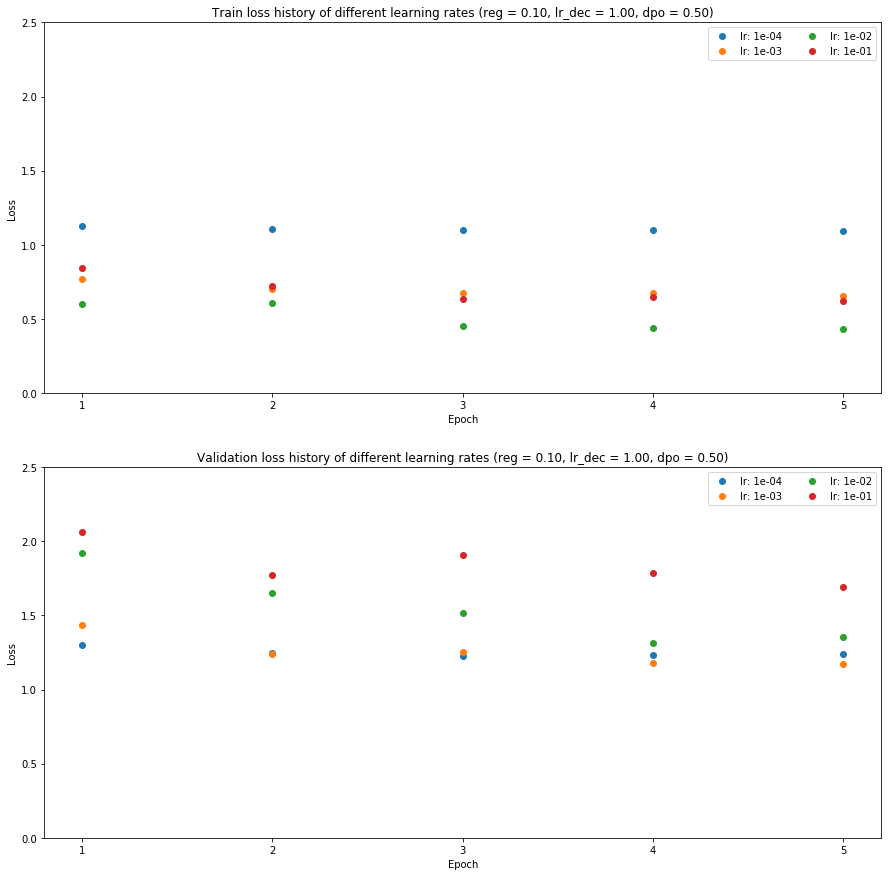

In [77]:
# Now for selected reg, dpo and lr_dec, let's print train and validation loss histories for all the learning rates

reg    = 0.1
lr_dec = 1.0
dpo    = 0.5

train_losses_lr = []
val_losses_lr = []
for lr in learn_rates:
    train_losses_lr.append(train_hists[(lr, reg, lr_dec, dpo)]['loss'])
    val_losses_lr.append(val_hists[(lr, reg, lr_dec, dpo)]['loss'])

epochs = [e for e in range(1,6)]
    
plt.subplot(2, 1, 1)
for lr, tr_loss_hist in zip(learn_rates, train_losses_lr):
    plt.plot(epochs, tr_loss_hist, 'o', label="lr: {:.0e}".format(lr))
plt.xticks(epochs)
plt.ylim([0, 2.5])
plt.title('Train loss history of different learning rates (reg = {:.2f}, lr_dec = {:.2f}, dpo = {:.2f})'\
          .format(reg, lr_dec, dpo))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(ncol=2, loc='upper right')
  
plt.subplot(2, 1, 2)
for lr, val_loss_hist in zip(learn_rates, val_losses_lr):
    plt.plot(epochs, val_loss_hist, 'o', label="lr: {:.0e}".format(lr))
plt.xticks(epochs)
plt.ylim([0, 2.5])
plt.title('Validation loss history of different learning rates (reg = {:.2f}, lr_dec = {:.2f}, dpo = {:.2f})'\
          .format(reg, lr_dec, dpo))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(ncol=2, loc='upper right')

plt.gcf().set_size_inches(15, 15)
plt.show()

In [76]:
# From the graph it seems that lr = 0.001 always outperforms 0.01 on validation.
# (I tried the above graph also with different reg strengths)
# 0.01 converges faster but is prone to overfitting.

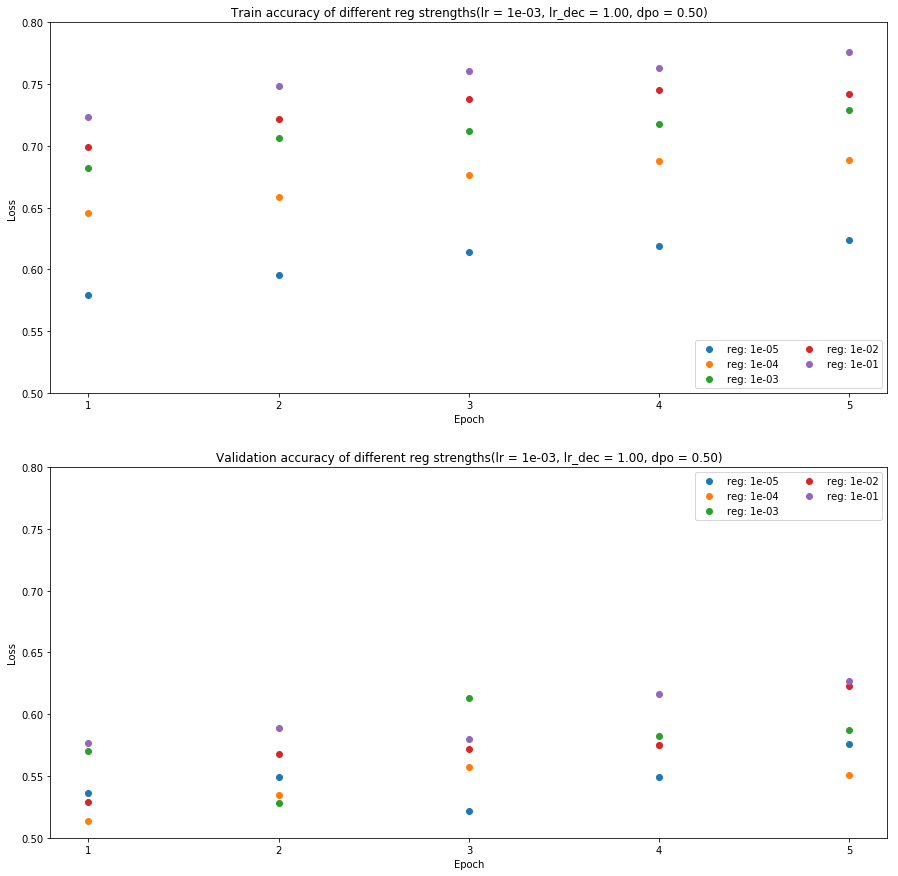

In [74]:
# Now let's plot accuracies at all regularization strengths

lr     = 0.001
lr_dec = 1.0
dpo    = 0.5

train_accs_reg = []
val_accs_reg = []
for reg in reg_strengths:
    train_accs_reg.append(train_hists[(lr, reg, lr_dec, dpo)]['acc'])
    val_accs_reg.append(val_hists[(lr, reg, lr_dec, dpo)]['acc'])

epochs = [e for e in range(1,6)]
    
plt.subplot(2, 1, 1)
for reg, tr_acc_hist in zip(reg_strengths, train_accs_reg):
    plt.plot(epochs, tr_acc_hist, 'o', label="reg: {:.0e}".format(reg))
plt.xticks(epochs)
plt.ylim([0.5, 0.8])
plt.title('Train accuracy of different reg strengths(lr = {:.0e}, lr_dec = {:.2f}, dpo = {:.2f})'\
          .format(lr, lr_dec, dpo))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(2, 1, 2)
for reg, val_acc_hist in zip(reg_strengths, val_accs_reg):
    plt.plot(epochs, val_acc_hist, 'o', label="reg: {:.0e}".format(reg))
plt.xticks(epochs)
plt.ylim([0.5, 0.8])
plt.title('Validation accuracy of different reg strengths(lr = {:.0e}, lr_dec = {:.2f}, dpo = {:.2f})'\
          .format(lr, lr_dec, dpo))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='upper right')

plt.gcf().set_size_inches(15, 15)
plt.show()

In [ ]:
# Reg 0.1 seems to perform the best but also has higher overfitting.
# 0.01 has almost the same validation accuracy but suggests less overfitting due to the lower training accuracy.

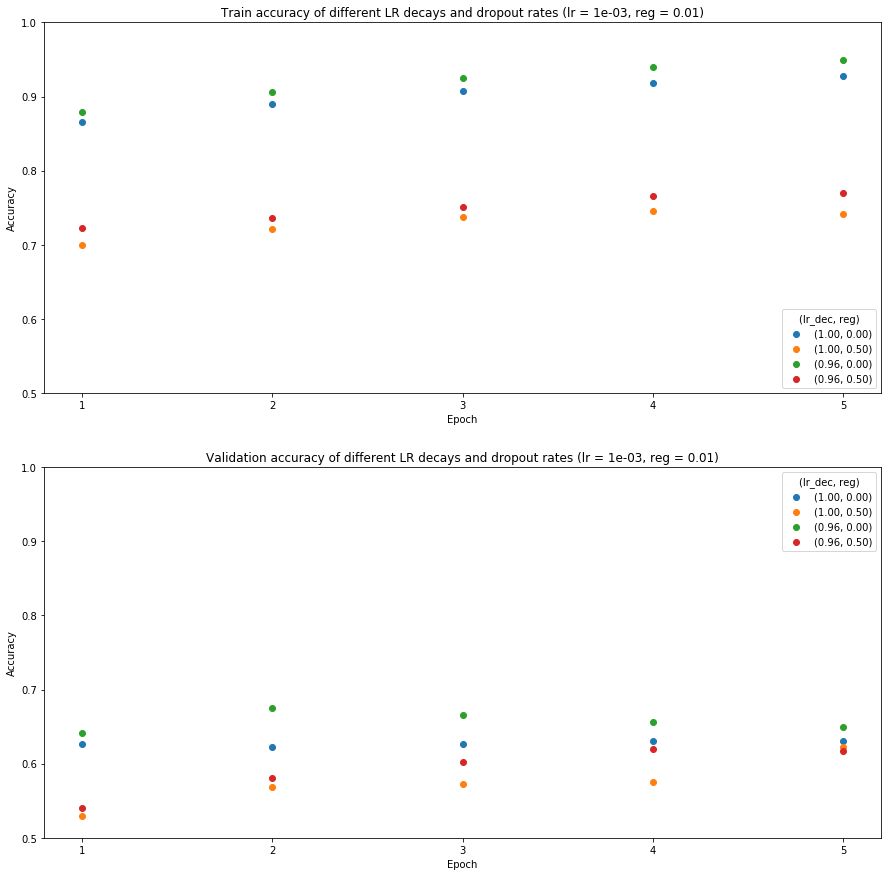

In [88]:
# With set learning rate and reg strength, plot accuracies on different lr decays and dropout rates.

lr  = 0.001
reg = 0.01

train_accs_dec_dpo = []
val_accs_dec_dpo = []
dec_dpo = []
for lr_dec, dpo in itertools.product(lr_decays, dropout_rates):
    train_accs_dec_dpo.append(train_hists[(lr, reg, lr_dec, dpo)]['acc'])
    val_accs_dec_dpo.append(val_hists[(lr, reg, lr_dec, dpo)]['acc'])
    dec_dpo.append((lr_dec, dpo))

epochs = [e for e in range(1,6)]
    
plt.subplot(2, 1, 1)
for (lr_dec, dpo), tr_acc_hist in zip(dec_dpo, train_accs_dec_dpo):
    plt.plot(epochs, tr_acc_hist, 'o', label="({:.2f}, {:.2f})".format(lr_dec, dpo))
plt.xticks(epochs)
plt.ylim([0.5, 1.0])
plt.title('Train accuracy of different LR decays and dropout rates (lr = {:.0e}, reg = {:.2f})'\
          .format(lr, reg))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title="(lr_dec, reg)", ncol=1, loc='lower right')
  
plt.subplot(2, 1, 2)
for (lr_dec, dpo), val_acc_hist in zip(dec_dpo, val_accs_dec_dpo):
    plt.plot(epochs, val_acc_hist, 'o', label="({:.2f}, {:.2f})".format(lr_dec, dpo))    
plt.xticks(epochs)
plt.ylim([0.5, 1.0])
plt.title('Validation accuracy of different LR decays and dropout rates (lr = {:.0e}, reg = {:.2f})'\
          .format(lr, reg))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title="(lr_dec, reg)", ncol=1, loc='upper right')

plt.gcf().set_size_inches(15, 15)
plt.show()

In [92]:
# Dropout definitely helps with overfitting. A higher value might be worth it.
# LR decay seems to perform well with dropout but might lead to faster convergence and therefore overfitting.
# Overfitting is especially bad when training on 1/5 subset of the original training batch.

In [93]:
# From the previous big run: 665 s for 5 epochs, each with 153 iterations
#   => 665 s / 5 = ~ 2.3 minutes per epoch / 153 = ~ 900 ms per iteration
#
# Let's see how the following values perform with longer training (15 epochs, time for lunch):
#   Learning rate: 1e-3
#   Reg strength:  1e-2
#   LR decay:      1
#   Dropout:       0.5
#
# Using the same smaller subset

lr     = 1e-3
reg    = 1e-2
lr_dec = 1.0
dpo    = 0.5

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_hist, val_hist = run_my_model(sess, y_out, mean_loss,
                                        X_train_small, y_train_small, X_val, y_val,
                                        epochs=15, batch_size=64, print_every=50,
                                        plot_losses=False, val_every_epoch=True, training=train_step,
                                        lr=lr, reg=reg, lr_dec=lr_dec, dpo=dpo)

Epoch 1/15 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 2.429, accuracy = 0.141
Iteration  50:  minibatch training loss = 1.862, accuracy = 0.250
Iteration 100:  minibatch training loss = 1.764, accuracy = 0.344
Iteration 150:  minibatch training loss = 1.684, accuracy = 0.375
Loss: 1.808 | Accuracy: 0.334 (training, average)
Loss: 1.905 | Accuracy: 0.320 (validation)

Epoch 2/15 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 1.680, accuracy = 0.422
Iteration  50:  minibatch training loss = 1.690, accuracy = 0.391
Iteration 100:  minibatch training loss = 1.595, accuracy = 0.359
Iteration 150:  minibatch training loss = 1.572, accuracy = 0.484
Loss: 1.616 | Accuracy: 0.412 (training, average)
Loss: 1.595 | Accuracy: 0.419 (validation)

Epoch 3/15 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 1.503, accuracy = 0.500
Iteration  50:  minibatch training loss = 1.607, accuracy = 0.391
Iteration 100:  minibatch training loss =

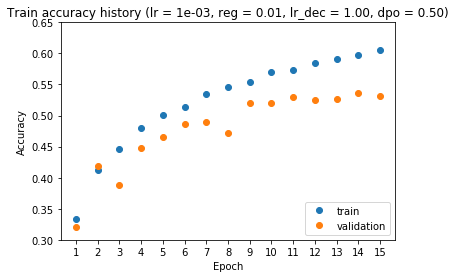

In [100]:
# Plot training and validation accuracies

epochs = [e for e in range(1,16)]

plt.subplot(1, 1, 1)
plt.plot(epochs, train_hist['acc'], 'o', label="train")
plt.plot(epochs, val_hist['acc'], 'o', label="validation")
plt.xticks(epochs)
plt.ylim([0.3, 0.65])
plt.title('Train accuracy history (lr = {:.0e}, reg = {:.2f}, lr_dec = {:.2f}, dpo = {:.2f})'\
          .format(lr, reg, lr_dec, dpo))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=1, loc='lower right')

#plt.gcf().set_size_inches(15, 15)
plt.show()

### Ooops!

The computed accuracy is very different in epoch 5 than in the coarse search.
I just realized that in the coarse search I didn't reset the model (session) with each hyperparameter iteration.
Thus I've been training one model over and over again (80\*5 times), just changing the hyperparameters every 5 epochs.
That explains why every training session (except the first one) starts with about the same accuracy as the previous run!
The above observations should still be valid to some extent since the trend is still visible.

Oh well, shit happens but I'm not gonna go through it again...

In [107]:
# Quickly test rome learning rates again

# Smaller random subset for faster training
idxs = np.random.randint(0, len(X_train), len(X_train) // 19) # aiming for 40 iteratins per epoch
X_train_small = X_train[idxs, ...]
y_train_small = y_train[idxs, ...]

print("Random subset size:")
print("X_train:", X_train_small.shape)
print("y_train:", y_train_small.shape)
print("")

learn_rates   = np.logspace(-4, -2, 3)  # 10^(-4 to -2)
reg_strengths = [0.01]
lr_decays     = [1]
dropout_rates = [0.50]

num_combs = len(learn_rates) * len(reg_strengths) * len(lr_decays) * len(dropout_rates)

train_hists = {}
val_hists = {}
best_acc = 0.0
best_hyps = ()

import itertools
from time import time

print('Training\n')
for i, (lr, reg, lr_dec, dpo) in enumerate(itertools.product(learn_rates, reg_strengths, lr_decays, dropout_rates)):

    t0 = time()
    print('-' * 80)
    print("Hyperparameters {}/{}: lr = {:.1e} | reg = {:.1e} | lr_dec = {:.2f} | dpo = {:.2f}"\
          .format(i+1, num_combs, lr, reg, lr_dec, dpo))
    print('-' * 80)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())        
        train_hist, val_hist = run_my_model(sess, y_out, mean_loss,
                                            X_train_small, y_train_small, X_val, y_val,
                                            epochs=5, batch_size=64, print_every=10,
                                            plot_losses=False, val_every_epoch=True, training=train_step,
                                            lr=lr, reg=reg, lr_dec=lr_dec, dpo=dpo)
        
    train_hists[(lr, reg, lr_dec, dpo)] = train_hist
    if val_hist:
        val_hists[(lr, reg, lr_dec, dpo)] = val_hist
        if val_hist['acc'][-1] > best_acc:
            best_hyps = (lr, reg, lr_dec, dpo)
            best_acc = val_hist['acc'][-1]
            
    t1 = time()
    print("Done in {:.0f}s.\n".format(t1 - t0))
    
if best_hyps:
    print("\nBest hyperparameters: lr = {:.2e}, reg = {:.2e}, lr_dec = {:.3f}, dpo = {:.3f}"\
          .format(best_hyps[0], best_hyps[1], best_hyps[2], best_hyps[3]))
    print("with validation accuracy {:.3g}".format(best_acc))

Random subset size:
X_train: (2578, 32, 32, 3)
y_train: (2578,)

Training

--------------------------------------------------------------------------------
Hyperparameters 1/3: lr = 1.0e-04 | reg = 1.0e-02 | lr_dec = 1.00 | dpo = 0.50
--------------------------------------------------------------------------------
Epoch 1/5 (learning rate 1.000e-04)
Iteration   0:  minibatch training loss = 2.346, accuracy = 0.141
Iteration  10:  minibatch training loss = 2.158, accuracy = 0.219
Iteration  20:  minibatch training loss = 2.238, accuracy = 0.141
Iteration  30:  minibatch training loss = 2.132, accuracy = 0.188
Iteration  40:  minibatch training loss = 2.156, accuracy = 0.111
Loss: 2.218 | Accuracy: 0.176 (training, average)
Loss: 2.947 | Accuracy: 0.128 (validation)

Epoch 2/5 (learning rate 1.000e-04)
Iteration   0:  minibatch training loss = 2.029, accuracy = 0.250
Iteration  10:  minibatch training loss = 1.966, accuracy = 0.391
Iteration  20:  minibatch training loss = 2.094, accurac

In [109]:
# Seems to confirm that the value around 1e-3 is correct

In [110]:
# Testing more dropout values

# Smaller random subset for faster training
idxs = np.random.randint(0, len(X_train), len(X_train) // 19) # aiming for 40 iteratins per epoch
X_train_small = X_train[idxs, ...]
y_train_small = y_train[idxs, ...]

print("Random subset size:")
print("X_train:", X_train_small.shape)
print("y_train:", y_train_small.shape)
print("")

learn_rates   = [0.001]
reg_strengths = [0.01]
lr_decays     = [1]
dropout_rates = [0.75, 0.9] # We know how 0.5 performs already

num_combs = len(learn_rates) * len(reg_strengths) * len(lr_decays) * len(dropout_rates)

train_hists = {}
val_hists = {}
best_acc = 0.0
best_hyps = ()

import itertools
from time import time

print('Training\n')
for i, (lr, reg, lr_dec, dpo) in enumerate(itertools.product(learn_rates, reg_strengths, lr_decays, dropout_rates)):
    t0 = time()
    print('-' * 80)
    print("Hyperparameters {}/{}: lr = {:.1e} | reg = {:.1e} | lr_dec = {:.2f} | dpo = {:.2f}"\
          .format(i+1, num_combs, lr, reg, lr_dec, dpo))
    print('-' * 80)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())        
        train_hist, val_hist = run_my_model(sess, y_out, mean_loss,
                                            X_train_small, y_train_small, X_val, y_val,
                                            epochs=10, batch_size=64, print_every=10,
                                            plot_losses=False, val_every_epoch=True, training=train_step,
                                            lr=lr, reg=reg, lr_dec=lr_dec, dpo=dpo)
        
    train_hists[(lr, reg, lr_dec, dpo)] = train_hist
    if val_hist:
        val_hists[(lr, reg, lr_dec, dpo)] = val_hist
        if val_hist['acc'][-1] > best_acc:
            best_hyps = (lr, reg, lr_dec, dpo)
            best_acc = val_hist['acc'][-1]
            
    t1 = time()
    print("Done in {:.0f}s.\n".format(t1 - t0))
    
if best_hyps:
    print("\nBest hyperparameters: lr = {:.2e}, reg = {:.2e}, lr_dec = {:.3f}, dpo = {:.3f}"\
          .format(best_hyps[0], best_hyps[1], best_hyps[2], best_hyps[3]))
    print("with validation accuracy {:.3g}".format(best_acc))

Random subset size:
X_train: (2578, 32, 32, 3)
y_train: (2578,)

Training

--------------------------------------------------------------------------------
Hyperparameters 1/2: lr = 1.0e-03 | reg = 1.0e-02 | lr_dec = 1.00 | dpo = 0.75
--------------------------------------------------------------------------------
Epoch 1/10 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 2.414, accuracy = 0.125
Iteration  10:  minibatch training loss = 2.150, accuracy = 0.141
Iteration  20:  minibatch training loss = 1.975, accuracy = 0.203
Iteration  30:  minibatch training loss = 1.873, accuracy = 0.312
Iteration  40:  minibatch training loss = 1.996, accuracy = 0.222
Loss: 2.022 | Accuracy: 0.237 (training, average)
Loss: 6.233 | Accuracy: 0.148 (validation)

Epoch 2/10 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 1.817, accuracy = 0.359
Iteration  10:  minibatch training loss = 1.892, accuracy = 0.328
Iteration  20:  minibatch training loss = 1.834, accur

Iteration  40:  minibatch training loss = 1.467, accuracy = 0.389
Loss: 1.717 | Accuracy: 0.363 (training, average)
Loss: 1.762 | Accuracy: 0.324 (validation)

Epoch 8/10 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 1.711, accuracy = 0.359
Iteration  10:  minibatch training loss = 1.810, accuracy = 0.344
Iteration  20:  minibatch training loss = 1.662, accuracy = 0.406
Iteration  30:  minibatch training loss = 1.678, accuracy = 0.375
Iteration  40:  minibatch training loss = 1.473, accuracy = 0.389
Loss: 1.697 | Accuracy: 0.369 (training, average)
Loss: 1.745 | Accuracy: 0.349 (validation)

Epoch 9/10 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 1.768, accuracy = 0.328
Iteration  10:  minibatch training loss = 1.870, accuracy = 0.328
Iteration  20:  minibatch training loss = 1.669, accuracy = 0.359
Iteration  30:  minibatch training loss = 1.723, accuracy = 0.359
Iteration  40:  minibatch training loss = 1.434, accuracy = 0.389
Loss: 1.684 

#### Results of dropout test (lr = 1.00e-03, reg = 1.00e-02, lr_dec = 1.000)


| dropout | train_acc | val_acc  |
| ------- |:---------:|:--------:|
| 0.50\*  |      0.57 |     0.52 |
| 0.75    |      0.47 |     0.40 |
| 0.90    |      0.37 |     0.35 |

(\*dropout 0.5 was taken from the 15-epoch test which used 1/5 subset instead of 1/19 subset of the train data)

0.75 seems to be OK.
The higher accuracy of 0.5 is probably caused by larger subset.
0.9 seems to be too much.

In [111]:
# Testing more LR decays

# Smaller random subset for faster training
idxs = np.random.randint(0, len(X_train), len(X_train) // 19) # aiming for 40 iteratins per epoch
X_train_small = X_train[idxs, ...]
y_train_small = y_train[idxs, ...]

print("Random subset size:")
print("X_train:", X_train_small.shape)
print("y_train:", y_train_small.shape)
print("")

learn_rates   = [0.001]
reg_strengths = [0.01]
lr_decays     = [0.9, 0.95, 0.99]  # We know 1 already
dropout_rates = [0.75]

num_combs = len(learn_rates) * len(reg_strengths) * len(lr_decays) * len(dropout_rates)

train_hists = {}
val_hists = {}
best_acc = 0.0
best_hyps = ()

import itertools
from time import time

print('Training\n')
for i, (lr, reg, lr_dec, dpo) in enumerate(itertools.product(learn_rates, reg_strengths, lr_decays, dropout_rates)):
    t0 = time()
    print('-' * 80)
    print("Hyperparameters {}/{}: lr = {:.1e} | reg = {:.1e} | lr_dec = {:.2f} | dpo = {:.2f}"\
          .format(i+1, num_combs, lr, reg, lr_dec, dpo))
    print('-' * 80)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())        
        train_hist, val_hist = run_my_model(sess, y_out, mean_loss,
                                            X_train_small, y_train_small, X_val, y_val,
                                            epochs=10, batch_size=64, print_every=10,
                                            plot_losses=False, val_every_epoch=True, training=train_step,
                                            lr=lr, reg=reg, lr_dec=lr_dec, dpo=dpo)
        
    train_hists[(lr, reg, lr_dec, dpo)] = train_hist
    if val_hist:
        val_hists[(lr, reg, lr_dec, dpo)] = val_hist
        if val_hist['acc'][-1] > best_acc:
            best_hyps = (lr, reg, lr_dec, dpo)
            best_acc = val_hist['acc'][-1]
            
    t1 = time()
    print("Done in {:.0f}s.\n".format(t1 - t0))
    
if best_hyps:
    print("\nBest hyperparameters: lr = {:.2e}, reg = {:.2e}, lr_dec = {:.3f}, dpo = {:.3f}"\
          .format(best_hyps[0], best_hyps[1], best_hyps[2], best_hyps[3]))
    print("with validation accuracy {:.3g}".format(best_acc))

Random subset size:
X_train: (2578, 32, 32, 3)
y_train: (2578,)

Training

--------------------------------------------------------------------------------
Hyperparameters 1/3: lr = 1.0e-03 | reg = 1.0e-02 | lr_dec = 0.90 | dpo = 0.75
--------------------------------------------------------------------------------
Epoch 1/10 (learning rate 1.000e-03)
Iteration   0:  minibatch training loss = 2.383, accuracy = 0.078
Iteration  10:  minibatch training loss = 1.935, accuracy = 0.297
Iteration  20:  minibatch training loss = 2.019, accuracy = 0.219
Iteration  30:  minibatch training loss = 1.879, accuracy = 0.266
Iteration  40:  minibatch training loss = 2.174, accuracy = 0.278
Loss: 2.041 | Accuracy: 0.236 (training, average)
Loss: 7.332 | Accuracy: 0.142 (validation)

Epoch 2/10 (learning rate 9.000e-04)
Iteration   0:  minibatch training loss = 1.872, accuracy = 0.281
Iteration  10:  minibatch training loss = 1.766, accuracy = 0.359
Iteration  20:  minibatch training loss = 1.869, accur

Iteration  40:  minibatch training loss = 1.522, accuracy = 0.444
Loss: 1.604 | Accuracy: 0.402 (training, average)
Loss: 1.644 | Accuracy: 0.400 (validation)

Epoch 8/10 (learning rate 6.983e-04)
Iteration   0:  minibatch training loss = 1.596, accuracy = 0.359
Iteration  10:  minibatch training loss = 1.681, accuracy = 0.328
Iteration  20:  minibatch training loss = 1.531, accuracy = 0.359
Iteration  30:  minibatch training loss = 1.589, accuracy = 0.406
Iteration  40:  minibatch training loss = 1.460, accuracy = 0.556
Loss: 1.575 | Accuracy: 0.412 (training, average)
Loss: 1.616 | Accuracy: 0.398 (validation)

Epoch 9/10 (learning rate 6.634e-04)
Iteration   0:  minibatch training loss = 1.587, accuracy = 0.375
Iteration  10:  minibatch training loss = 1.667, accuracy = 0.344
Iteration  20:  minibatch training loss = 1.563, accuracy = 0.359
Iteration  30:  minibatch training loss = 1.537, accuracy = 0.406
Iteration  40:  minibatch training loss = 1.403, accuracy = 0.556
Loss: 1.551 

#### Results of LR decay test (lr = 1.00e-03, reg = 1.00e-02, dpo = 0.75)

| lr_dec | train_acc | val_acc  |
| ------ |:---------:|:--------:|
| 0.90   |      0.43 |     0.38 |
| 0.95   |      0.44 |     0.42 |
| 0.99   |      0.46 |     0.35 |

0.95 is the winner.
It actually seems to prevent overfitting.
0.90 decreases learning speed.
0.99 doesn't do much and seems to learn too fast with some overfitting.

In [147]:
# Now finally the fine tuning on focused ranges.
# Based on previous attempts (and fails) I chose these intervals:
#
#   Learning rate : 10^(-3.25 to -1.75)  ~ between 0.001 and 0.01 with small margins
#   Reg strength  : 10^(-2.25 to -0.75)  ~ between 0.01 and 0.1 with small margins
#   LR decay      : 0.93 to 0.97
#   Dropout       : 0.65 to 0.85

lr_range     = (-3.25, -1.75)
reg_range    = (-2.25, -0.75)
lr_dec_range = (0.93, 0.97)
dpo_range    = (0.65, 0.85)

# random generation functions
lr_fn = reg_fn = lambda x,y: 10**np.random.uniform(x,y)  # log range
lr_dec_fn = dpo_fn = lambda x,y: np.random.uniform(x,y)  # lin range

# train indefinitely
num = 9999
# use time restriction instead
hours_to_run = 63

hyp_iter = hyperparameters((lr_fn, reg_fn, lr_dec_fn, dpo_fn),
                           (lr_range, reg_range, lr_dec_range, dpo_range),
                           num)

train_hists = {}
val_hists = {}
best_acc = 0.0
best_hyps = ()

import datetime

now = datetime.datetime.now()                 # Fri 6pm
end_time = now + datetime.timedelta(hours=63) # Mon 9am

for i, (lr, reg, lr_dec, dpo) in enumerate(hyp_iter):
    t0 = time()
    print('-' * 80)
    print("Hyperparameters {}/{}: lr = {:.3e} | reg = {:.3e} | lr_dec = {:.3f} | dpo = {:.3f}"\
          .format(i+1, num, lr, reg, lr_dec, dpo))
    print('-' * 80)
    
    # 1/4 random subset for faster training
    idxs = np.random.randint(0, len(X_train), len(X_train) // 4)
    X_train_small = X_train[idxs, ...]
    y_train_small = y_train[idxs, ...]
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Train for 12 epochs over random 1/4 subset of training set with batch size 64
        train_hist, val_hist = run_my_model(sess, y_out, mean_loss,
                                            X_train_small, y_train_small, X_val, y_val,
                                            epochs=12, batch_size=64, print_every=150,
                                            plot_losses=False, val_every_epoch=True, training=train_step,
                                            lr=lr, reg=reg, lr_dec=lr_dec, dpo=dpo)
        
        train_hists[(lr, reg, lr_dec, dpo)] = train_hist
        if val_hist:
            val_hists[(lr, reg, lr_dec, dpo)] = val_hist
            if val_hist['acc'][-1] > best_acc:
                best_hyps = (lr, reg, lr_dec, dpo)
                best_acc = val_hist['acc'][-1]
                # Write best accuracy to file
                with open("CNN_results.txt", "a") as f:
                    time_format = "%a %X"
                    timestamp = datetime.datetime.now().astimezone()
                    time_str = timestamp.strftime(time_format)                    
                    hyp_str = "lr = {:.3e} | reg = {:.3e} | lr_dec = {:.3f} | dpo = {:.3f}".format(lr, reg, lr_dec, dpo)
                    f.write("{:.3f} ( {} ) at {}\n".format(best_acc, hyp_str, time_str))
            
    t1 = time()
    print("Done in {:.0f}s.\n".format(t1 - t0))
    
    # If ran out of time, stop
    if datetime.datetime.now() >= end_time:
        print("Ran out of time. Ending the training.")
        break
    
if best_hyps:
    print("\nBest hyperparameters: lr = {:.2e}, reg = {:.2e}, lr_dec = {:.3f}, dpo = {:.3f}"\
          .format(best_hyps[0], best_hyps[1], best_hyps[2], best_hyps[3]))
    print("with validation accuracy {:.3g}".format(best_acc))

--------------------------------------------------------------------------------
Hyperparameters 1/9999: lr = 7.037e-04 | reg = 7.861e-03 | lr_dec = 0.935 | dpo = 0.793
--------------------------------------------------------------------------------
Epoch 1/12 (learning rate 7.037e-04)
Iteration   0:  minibatch training loss = 2.687, accuracy = 0.062
Iteration 150:  minibatch training loss = 1.726, accuracy = 0.344
Loss: 1.886 | Accuracy: 0.295 (training, average)
Loss: 1.748 | Accuracy: 0.336 (validation)

Epoch 2/12 (learning rate 6.583e-04)
Iteration   0:  minibatch training loss = 1.475, accuracy = 0.516
Iteration 150:  minibatch training loss = 1.626, accuracy = 0.406
Loss: 1.665 | Accuracy: 0.386 (training, average)
Loss: 1.622 | Accuracy: 0.385 (validation)

Epoch 3/12 (learning rate 6.158e-04)
Iteration   0:  minibatch training loss = 1.328, accuracy = 0.500
Iteration 150:  minibatch training loss = 1.529, accuracy = 0.438
Loss: 1.587 | Accuracy: 0.424 (training, average)
Loss:

Iteration 150:  minibatch training loss = 1.406, accuracy = 0.484
Loss: 1.499 | Accuracy: 0.461 (training, average)
Loss: 1.538 | Accuracy: 0.428 (validation)

Epoch 6/12 (learning rate 7.197e-04)
Iteration   0:  minibatch training loss = 1.489, accuracy = 0.500
Iteration 150:  minibatch training loss = 1.330, accuracy = 0.500
Loss: 1.468 | Accuracy: 0.476 (training, average)
Loss: 1.516 | Accuracy: 0.441 (validation)

Epoch 7/12 (learning rate 6.734e-04)
Iteration   0:  minibatch training loss = 1.496, accuracy = 0.422
Iteration 150:  minibatch training loss = 1.310, accuracy = 0.531
Loss: 1.437 | Accuracy: 0.482 (training, average)
Loss: 1.483 | Accuracy: 0.451 (validation)

Epoch 8/12 (learning rate 6.301e-04)
Iteration   0:  minibatch training loss = 1.464, accuracy = 0.484
Iteration 150:  minibatch training loss = 1.368, accuracy = 0.500
Loss: 1.410 | Accuracy: 0.494 (training, average)
Loss: 1.430 | Accuracy: 0.486 (validation)

Epoch 9/12 (learning rate 5.896e-04)
Iteration   0:

Loss: 1.347 | Accuracy: 0.514 (training, average)
Loss: 1.423 | Accuracy: 0.496 (validation)

Epoch 11/12 (learning rate 1.116e-03)
Iteration   0:  minibatch training loss = 1.221, accuracy = 0.562
Iteration 150:  minibatch training loss = 1.324, accuracy = 0.578
Loss: 1.323 | Accuracy: 0.522 (training, average)
Loss: 1.380 | Accuracy: 0.503 (validation)

Epoch 12/12 (learning rate 1.058e-03)
Iteration   0:  minibatch training loss = 1.226, accuracy = 0.594
Iteration 150:  minibatch training loss = 1.266, accuracy = 0.578
Loss: 1.309 | Accuracy: 0.532 (training, average)
Loss: 1.347 | Accuracy: 0.513 (validation)

Done in 1975s.

--------------------------------------------------------------------------------
Hyperparameters 6/9999: lr = 5.240e-03 | reg = 5.857e-02 | lr_dec = 0.931 | dpo = 0.806
--------------------------------------------------------------------------------
Epoch 1/12 (learning rate 5.240e-03)
Iteration   0:  minibatch training loss = 2.361, accuracy = 0.172
Iteration

Loss: 1.617 | Accuracy: 0.407 (validation)

Epoch 3/12 (learning rate 1.108e-02)
Iteration   0:  minibatch training loss = 1.607, accuracy = 0.438
Iteration 150:  minibatch training loss = 1.465, accuracy = 0.406
Loss: 1.506 | Accuracy: 0.447 (training, average)
Loss: 1.522 | Accuracy: 0.441 (validation)

Epoch 4/12 (learning rate 1.049e-02)
Iteration   0:  minibatch training loss = 1.434, accuracy = 0.484
Iteration 150:  minibatch training loss = 1.266, accuracy = 0.484
Loss: 1.434 | Accuracy: 0.480 (training, average)
Loss: 1.509 | Accuracy: 0.454 (validation)

Epoch 5/12 (learning rate 9.940e-03)
Iteration   0:  minibatch training loss = 1.397, accuracy = 0.469
Iteration 150:  minibatch training loss = 1.319, accuracy = 0.469
Loss: 1.377 | Accuracy: 0.503 (training, average)
Loss: 1.501 | Accuracy: 0.465 (validation)

Epoch 6/12 (learning rate 9.415e-03)
Iteration   0:  minibatch training loss = 1.323, accuracy = 0.516
Iteration 150:  minibatch training loss = 1.217, accuracy = 0.50

Iteration   0:  minibatch training loss = 1.324, accuracy = 0.547
Iteration 150:  minibatch training loss = 1.561, accuracy = 0.391
Loss: 1.427 | Accuracy: 0.479 (training, average)
Loss: 1.455 | Accuracy: 0.477 (validation)

Epoch 9/12 (learning rate 1.034e-02)
Iteration   0:  minibatch training loss = 1.318, accuracy = 0.562
Iteration 150:  minibatch training loss = 1.601, accuracy = 0.391
Loss: 1.400 | Accuracy: 0.489 (training, average)
Loss: 1.376 | Accuracy: 0.517 (validation)

Epoch 10/12 (learning rate 1.000e-02)
Iteration   0:  minibatch training loss = 1.273, accuracy = 0.547
Iteration 150:  minibatch training loss = 1.559, accuracy = 0.422
Loss: 1.378 | Accuracy: 0.504 (training, average)
Loss: 1.381 | Accuracy: 0.511 (validation)

Epoch 11/12 (learning rate 9.675e-03)
Iteration   0:  minibatch training loss = 1.291, accuracy = 0.531
Iteration 150:  minibatch training loss = 1.492, accuracy = 0.500
Loss: 1.359 | Accuracy: 0.509 (training, average)
Loss: 1.408 | Accuracy: 0.5

Epoch 1/12 (learning rate 6.370e-04)
Iteration   0:  minibatch training loss = 2.377, accuracy = 0.078
Iteration 150:  minibatch training loss = 1.800, accuracy = 0.344
Loss: 1.883 | Accuracy: 0.307 (training, average)
Loss: 1.897 | Accuracy: 0.290 (validation)

Epoch 2/12 (learning rate 6.167e-04)
Iteration   0:  minibatch training loss = 1.726, accuracy = 0.391
Iteration 150:  minibatch training loss = 1.678, accuracy = 0.406
Loss: 1.677 | Accuracy: 0.383 (training, average)
Loss: 1.648 | Accuracy: 0.387 (validation)

Epoch 3/12 (learning rate 5.972e-04)
Iteration   0:  minibatch training loss = 1.616, accuracy = 0.422
Iteration 150:  minibatch training loss = 1.593, accuracy = 0.422
Loss: 1.604 | Accuracy: 0.410 (training, average)
Loss: 1.597 | Accuracy: 0.404 (validation)

Epoch 4/12 (learning rate 5.782e-04)
Iteration   0:  minibatch training loss = 1.585, accuracy = 0.453
Iteration 150:  minibatch training loss = 1.475, accuracy = 0.484
Loss: 1.542 | Accuracy: 0.437 (training, a

Iteration   0:  minibatch training loss = 1.485, accuracy = 0.484
Iteration 150:  minibatch training loss = 1.482, accuracy = 0.531
Loss: 1.426 | Accuracy: 0.481 (training, average)
Loss: 1.501 | Accuracy: 0.485 (validation)

Epoch 7/12 (learning rate 2.669e-03)
Iteration   0:  minibatch training loss = 1.492, accuracy = 0.516
Iteration 150:  minibatch training loss = 1.424, accuracy = 0.500
Loss: 1.403 | Accuracy: 0.493 (training, average)
Loss: 1.468 | Accuracy: 0.484 (validation)

Epoch 8/12 (learning rate 2.566e-03)
Iteration   0:  minibatch training loss = 1.382, accuracy = 0.531
Iteration 150:  minibatch training loss = 1.420, accuracy = 0.469
Loss: 1.374 | Accuracy: 0.503 (training, average)
Loss: 1.447 | Accuracy: 0.499 (validation)

Epoch 9/12 (learning rate 2.467e-03)
Iteration   0:  minibatch training loss = 1.443, accuracy = 0.562
Iteration 150:  minibatch training loss = 1.485, accuracy = 0.484
Loss: 1.356 | Accuracy: 0.509 (training, average)
Loss: 1.385 | Accuracy: 0.520

Iteration 150:  minibatch training loss = 1.447, accuracy = 0.484
Loss: 1.358 | Accuracy: 0.512 (training, average)
Loss: 1.397 | Accuracy: 0.503 (validation)

Epoch 12/12 (learning rate 2.961e-03)
Iteration   0:  minibatch training loss = 1.510, accuracy = 0.484
Iteration 150:  minibatch training loss = 1.419, accuracy = 0.562
Loss: 1.340 | Accuracy: 0.522 (training, average)
Loss: 1.367 | Accuracy: 0.508 (validation)

Done in 1991s.

--------------------------------------------------------------------------------
Hyperparameters 18/9999: lr = 6.169e-04 | reg = 2.237e-02 | lr_dec = 0.935 | dpo = 0.788
--------------------------------------------------------------------------------
Epoch 1/12 (learning rate 6.169e-04)
Iteration   0:  minibatch training loss = 2.376, accuracy = 0.047
Iteration 150:  minibatch training loss = 1.815, accuracy = 0.344
Loss: 1.902 | Accuracy: 0.293 (training, average)
Loss: 1.967 | Accuracy: 0.255 (validation)

Epoch 2/12 (learning rate 5.770e-04)
Iteration

Loss: 1.600 | Accuracy: 0.408 (training, average)
Loss: 1.656 | Accuracy: 0.381 (validation)

Epoch 4/12 (learning rate 5.051e-04)
Iteration   0:  minibatch training loss = 1.651, accuracy = 0.391
Iteration 150:  minibatch training loss = 1.691, accuracy = 0.344
Loss: 1.548 | Accuracy: 0.434 (training, average)
Loss: 1.613 | Accuracy: 0.402 (validation)

Epoch 5/12 (learning rate 4.799e-04)
Iteration   0:  minibatch training loss = 1.584, accuracy = 0.391
Iteration 150:  minibatch training loss = 1.657, accuracy = 0.359
Loss: 1.506 | Accuracy: 0.451 (training, average)
Loss: 1.560 | Accuracy: 0.413 (validation)

Epoch 6/12 (learning rate 4.559e-04)
Iteration   0:  minibatch training loss = 1.509, accuracy = 0.453
Iteration 150:  minibatch training loss = 1.587, accuracy = 0.375
Loss: 1.473 | Accuracy: 0.467 (training, average)
Loss: 1.503 | Accuracy: 0.452 (validation)

Epoch 7/12 (learning rate 4.331e-04)
Iteration   0:  minibatch training loss = 1.492, accuracy = 0.469
Iteration 150:

Loss: 1.338 | Accuracy: 0.517 (validation)

Epoch 9/12 (learning rate 1.182e-03)
Iteration   0:  minibatch training loss = 1.127, accuracy = 0.656
Iteration 150:  minibatch training loss = 1.410, accuracy = 0.484
Loss: 1.255 | Accuracy: 0.556 (training, average)
Loss: 1.343 | Accuracy: 0.505 (validation)

Epoch 10/12 (learning rate 1.101e-03)
Iteration   0:  minibatch training loss = 1.060, accuracy = 0.594
Iteration 150:  minibatch training loss = 1.390, accuracy = 0.484
Loss: 1.232 | Accuracy: 0.565 (training, average)
Loss: 1.305 | Accuracy: 0.537 (validation)

Epoch 11/12 (learning rate 1.025e-03)
Iteration   0:  minibatch training loss = 0.970, accuracy = 0.719
Iteration 150:  minibatch training loss = 1.427, accuracy = 0.516
Loss: 1.208 | Accuracy: 0.570 (training, average)
Loss: 1.303 | Accuracy: 0.542 (validation)

Epoch 12/12 (learning rate 9.545e-04)
Iteration   0:  minibatch training loss = 0.966, accuracy = 0.625
Iteration 150:  minibatch training loss = 1.338, accuracy = 0

Epoch 1/12 (learning rate 7.861e-03)
Iteration   0:  minibatch training loss = 2.427, accuracy = 0.078
Iteration 150:  minibatch training loss = 1.628, accuracy = 0.375
Loss: 1.847 | Accuracy: 0.310 (training, average)
Loss: 2.316 | Accuracy: 0.272 (validation)

Epoch 2/12 (learning rate 7.401e-03)
Iteration   0:  minibatch training loss = 1.741, accuracy = 0.375
Iteration 150:  minibatch training loss = 1.462, accuracy = 0.516
Loss: 1.648 | Accuracy: 0.389 (training, average)
Loss: 1.661 | Accuracy: 0.407 (validation)

Epoch 3/12 (learning rate 6.968e-03)
Iteration   0:  minibatch training loss = 1.629, accuracy = 0.344
Iteration 150:  minibatch training loss = 1.352, accuracy = 0.516
Loss: 1.559 | Accuracy: 0.424 (training, average)
Loss: 1.534 | Accuracy: 0.434 (validation)

Epoch 4/12 (learning rate 6.560e-03)
Iteration   0:  minibatch training loss = 1.495, accuracy = 0.406
Iteration 150:  minibatch training loss = 1.242, accuracy = 0.578
Loss: 1.488 | Accuracy: 0.453 (training, a

Iteration   0:  minibatch training loss = 1.399, accuracy = 0.516
Iteration 150:  minibatch training loss = 1.255, accuracy = 0.547
Loss: 1.339 | Accuracy: 0.518 (training, average)
Loss: 1.422 | Accuracy: 0.503 (validation)

Epoch 7/12 (learning rate 1.212e-02)
Iteration   0:  minibatch training loss = 1.292, accuracy = 0.547
Iteration 150:  minibatch training loss = 1.200, accuracy = 0.500
Loss: 1.283 | Accuracy: 0.540 (training, average)
Loss: 1.409 | Accuracy: 0.501 (validation)

Epoch 8/12 (learning rate 1.155e-02)
Iteration   0:  minibatch training loss = 1.246, accuracy = 0.531
Iteration 150:  minibatch training loss = 1.164, accuracy = 0.531
Loss: 1.251 | Accuracy: 0.547 (training, average)
Loss: 1.345 | Accuracy: 0.524 (validation)

Epoch 9/12 (learning rate 1.101e-02)
Iteration   0:  minibatch training loss = 1.231, accuracy = 0.531
Iteration 150:  minibatch training loss = 1.132, accuracy = 0.594
Loss: 1.214 | Accuracy: 0.565 (training, average)
Loss: 1.280 | Accuracy: 0.559

Iteration 150:  minibatch training loss = 1.631, accuracy = 0.547
Loss: 1.226 | Accuracy: 0.564 (training, average)
Loss: 1.271 | Accuracy: 0.555 (validation)

Epoch 12/12 (learning rate 2.645e-03)
Iteration   0:  minibatch training loss = 1.266, accuracy = 0.578
Iteration 150:  minibatch training loss = 1.395, accuracy = 0.609
Loss: 1.205 | Accuracy: 0.570 (training, average)
Loss: 1.256 | Accuracy: 0.557 (validation)

Done in 1970s.

--------------------------------------------------------------------------------
Hyperparameters 30/9999: lr = 7.349e-03 | reg = 5.258e-02 | lr_dec = 0.932 | dpo = 0.842
--------------------------------------------------------------------------------
Epoch 1/12 (learning rate 7.349e-03)
Iteration   0:  minibatch training loss = 2.552, accuracy = 0.109
Iteration 150:  minibatch training loss = 1.802, accuracy = 0.281
Loss: 1.847 | Accuracy: 0.303 (training, average)
Loss: 2.160 | Accuracy: 0.313 (validation)

Epoch 2/12 (learning rate 6.850e-03)
Iteration

Loss: 1.523 | Accuracy: 0.435 (training, average)
Loss: 1.711 | Accuracy: 0.382 (validation)

Epoch 4/12 (learning rate 8.670e-03)
Iteration   0:  minibatch training loss = 1.445, accuracy = 0.469
Iteration 150:  minibatch training loss = 1.284, accuracy = 0.484
Loss: 1.452 | Accuracy: 0.465 (training, average)
Loss: 1.568 | Accuracy: 0.440 (validation)

Epoch 5/12 (learning rate 8.064e-03)
Iteration   0:  minibatch training loss = 1.440, accuracy = 0.438
Iteration 150:  minibatch training loss = 1.254, accuracy = 0.531
Loss: 1.392 | Accuracy: 0.494 (training, average)
Loss: 1.489 | Accuracy: 0.470 (validation)

Epoch 6/12 (learning rate 7.501e-03)
Iteration   0:  minibatch training loss = 1.328, accuracy = 0.469
Iteration 150:  minibatch training loss = 1.318, accuracy = 0.531
Loss: 1.344 | Accuracy: 0.512 (training, average)
Loss: 1.412 | Accuracy: 0.487 (validation)

Epoch 7/12 (learning rate 6.976e-03)
Iteration   0:  minibatch training loss = 1.302, accuracy = 0.500
Iteration 150:

Loss: 1.443 | Accuracy: 0.479 (validation)

Epoch 9/12 (learning rate 5.176e-04)
Iteration   0:  minibatch training loss = 1.338, accuracy = 0.578
Iteration 150:  minibatch training loss = 1.415, accuracy = 0.531
Loss: 1.399 | Accuracy: 0.501 (training, average)
Loss: 1.417 | Accuracy: 0.472 (validation)

Epoch 10/12 (learning rate 4.881e-04)
Iteration   0:  minibatch training loss = 1.308, accuracy = 0.609
Iteration 150:  minibatch training loss = 1.356, accuracy = 0.469
Loss: 1.384 | Accuracy: 0.503 (training, average)
Loss: 1.401 | Accuracy: 0.479 (validation)

Epoch 11/12 (learning rate 4.603e-04)
Iteration   0:  minibatch training loss = 1.348, accuracy = 0.531
Iteration 150:  minibatch training loss = 1.357, accuracy = 0.469
Loss: 1.366 | Accuracy: 0.512 (training, average)
Loss: 1.401 | Accuracy: 0.489 (validation)

Epoch 12/12 (learning rate 4.341e-04)
Iteration   0:  minibatch training loss = 1.236, accuracy = 0.609
Iteration 150:  minibatch training loss = 1.367, accuracy = 0

Epoch 1/12 (learning rate 9.579e-03)
Iteration   0:  minibatch training loss = 2.389, accuracy = 0.141
Iteration 150:  minibatch training loss = 1.826, accuracy = 0.266
Loss: 1.842 | Accuracy: 0.308 (training, average)
Loss: 1.953 | Accuracy: 0.316 (validation)

Epoch 2/12 (learning rate 9.042e-03)
Iteration   0:  minibatch training loss = 1.797, accuracy = 0.297
Iteration 150:  minibatch training loss = 1.588, accuracy = 0.359
Loss: 1.625 | Accuracy: 0.394 (training, average)
Loss: 2.128 | Accuracy: 0.278 (validation)

Epoch 3/12 (learning rate 8.535e-03)
Iteration   0:  minibatch training loss = 1.705, accuracy = 0.438
Iteration 150:  minibatch training loss = 1.584, accuracy = 0.406
Loss: 1.531 | Accuracy: 0.439 (training, average)
Loss: 1.776 | Accuracy: 0.356 (validation)

Epoch 4/12 (learning rate 8.057e-03)
Iteration   0:  minibatch training loss = 1.676, accuracy = 0.406
Iteration 150:  minibatch training loss = 1.494, accuracy = 0.391
Loss: 1.474 | Accuracy: 0.461 (training, a

Iteration   0:  minibatch training loss = 1.483, accuracy = 0.438
Iteration 150:  minibatch training loss = 1.259, accuracy = 0.562
Loss: 1.371 | Accuracy: 0.510 (training, average)
Loss: 1.457 | Accuracy: 0.506 (validation)

Epoch 7/12 (learning rate 7.799e-03)
Iteration   0:  minibatch training loss = 1.478, accuracy = 0.484
Iteration 150:  minibatch training loss = 1.309, accuracy = 0.531
Loss: 1.327 | Accuracy: 0.527 (training, average)
Loss: 1.422 | Accuracy: 0.505 (validation)

Epoch 8/12 (learning rate 7.411e-03)
Iteration   0:  minibatch training loss = 1.396, accuracy = 0.469
Iteration 150:  minibatch training loss = 1.160, accuracy = 0.562
Loss: 1.286 | Accuracy: 0.540 (training, average)
Loss: 1.323 | Accuracy: 0.533 (validation)

Epoch 9/12 (learning rate 7.043e-03)
Iteration   0:  minibatch training loss = 1.363, accuracy = 0.484
Iteration 150:  minibatch training loss = 1.222, accuracy = 0.516
Loss: 1.252 | Accuracy: 0.554 (training, average)
Loss: 1.357 | Accuracy: 0.541

Iteration 150:  minibatch training loss = 1.135, accuracy = 0.516
Loss: 1.178 | Accuracy: 0.583 (training, average)
Loss: 1.239 | Accuracy: 0.564 (validation)

Epoch 12/12 (learning rate 4.654e-03)
Iteration   0:  minibatch training loss = 1.079, accuracy = 0.547
Iteration 150:  minibatch training loss = 1.159, accuracy = 0.531
Loss: 1.149 | Accuracy: 0.594 (training, average)
Loss: 1.242 | Accuracy: 0.570 (validation)

Done in 1982s.

--------------------------------------------------------------------------------
Hyperparameters 42/9999: lr = 1.731e-03 | reg = 3.313e-02 | lr_dec = 0.958 | dpo = 0.802
--------------------------------------------------------------------------------
Epoch 1/12 (learning rate 1.731e-03)
Iteration   0:  minibatch training loss = 2.249, accuracy = 0.172
Iteration 150:  minibatch training loss = 1.926, accuracy = 0.406
Loss: 1.861 | Accuracy: 0.305 (training, average)
Loss: 2.226 | Accuracy: 0.262 (validation)

Epoch 2/12 (learning rate 1.658e-03)
Iteration

Loss: 1.630 | Accuracy: 0.407 (training, average)
Loss: 1.634 | Accuracy: 0.399 (validation)

Epoch 4/12 (learning rate 4.687e-04)
Iteration   0:  minibatch training loss = 1.486, accuracy = 0.500
Iteration 150:  minibatch training loss = 1.702, accuracy = 0.406
Loss: 1.578 | Accuracy: 0.431 (training, average)
Loss: 1.569 | Accuracy: 0.430 (validation)

Epoch 5/12 (learning rate 4.381e-04)
Iteration   0:  minibatch training loss = 1.479, accuracy = 0.500
Iteration 150:  minibatch training loss = 1.701, accuracy = 0.406
Loss: 1.530 | Accuracy: 0.451 (training, average)
Loss: 1.502 | Accuracy: 0.464 (validation)

Epoch 6/12 (learning rate 4.095e-04)
Iteration   0:  minibatch training loss = 1.362, accuracy = 0.531
Iteration 150:  minibatch training loss = 1.650, accuracy = 0.391
Loss: 1.492 | Accuracy: 0.466 (training, average)
Loss: 1.488 | Accuracy: 0.455 (validation)

Epoch 7/12 (learning rate 3.828e-04)
Iteration   0:  minibatch training loss = 1.318, accuracy = 0.531
Iteration 150:

Loss: 1.370 | Accuracy: 0.519 (validation)

Epoch 9/12 (learning rate 5.247e-04)
Iteration   0:  minibatch training loss = 1.339, accuracy = 0.516
Iteration 150:  minibatch training loss = 1.366, accuracy = 0.469
Loss: 1.338 | Accuracy: 0.525 (training, average)
Loss: 1.344 | Accuracy: 0.533 (validation)

Epoch 10/12 (learning rate 4.988e-04)
Iteration   0:  minibatch training loss = 1.288, accuracy = 0.578
Iteration 150:  minibatch training loss = 1.358, accuracy = 0.484
Loss: 1.316 | Accuracy: 0.538 (training, average)
Loss: 1.347 | Accuracy: 0.513 (validation)

Epoch 11/12 (learning rate 4.741e-04)
Iteration   0:  minibatch training loss = 1.267, accuracy = 0.547
Iteration 150:  minibatch training loss = 1.358, accuracy = 0.469
Loss: 1.299 | Accuracy: 0.539 (training, average)
Loss: 1.342 | Accuracy: 0.532 (validation)

Epoch 12/12 (learning rate 4.507e-04)
Iteration   0:  minibatch training loss = 1.369, accuracy = 0.484
Iteration 150:  minibatch training loss = 1.342, accuracy = 0

Epoch 1/12 (learning rate 1.015e-03)
Iteration   0:  minibatch training loss = 2.351, accuracy = 0.109
Iteration 150:  minibatch training loss = 1.705, accuracy = 0.281
Loss: 1.806 | Accuracy: 0.331 (training, average)
Loss: 1.939 | Accuracy: 0.284 (validation)

Epoch 2/12 (learning rate 9.647e-04)
Iteration   0:  minibatch training loss = 1.670, accuracy = 0.359
Iteration 150:  minibatch training loss = 1.506, accuracy = 0.438
Loss: 1.611 | Accuracy: 0.408 (training, average)
Loss: 1.637 | Accuracy: 0.399 (validation)

Epoch 3/12 (learning rate 9.171e-04)
Iteration   0:  minibatch training loss = 1.634, accuracy = 0.391
Iteration 150:  minibatch training loss = 1.416, accuracy = 0.469
Loss: 1.520 | Accuracy: 0.445 (training, average)
Loss: 1.538 | Accuracy: 0.432 (validation)

Epoch 4/12 (learning rate 8.718e-04)
Iteration   0:  minibatch training loss = 1.680, accuracy = 0.422
Iteration 150:  minibatch training loss = 1.358, accuracy = 0.469
Loss: 1.465 | Accuracy: 0.475 (training, a

Iteration   0:  minibatch training loss = 1.521, accuracy = 0.391
Iteration 150:  minibatch training loss = 1.268, accuracy = 0.625
Loss: 1.436 | Accuracy: 0.486 (training, average)
Loss: 1.433 | Accuracy: 0.483 (validation)

Epoch 7/12 (learning rate 5.415e-04)
Iteration   0:  minibatch training loss = 1.557, accuracy = 0.422
Iteration 150:  minibatch training loss = 1.187, accuracy = 0.594
Loss: 1.406 | Accuracy: 0.499 (training, average)
Loss: 1.406 | Accuracy: 0.497 (validation)

Epoch 8/12 (learning rate 5.238e-04)
Iteration   0:  minibatch training loss = 1.550, accuracy = 0.391
Iteration 150:  minibatch training loss = 1.144, accuracy = 0.656
Loss: 1.385 | Accuracy: 0.505 (training, average)
Loss: 1.390 | Accuracy: 0.500 (validation)

Epoch 9/12 (learning rate 5.067e-04)
Iteration   0:  minibatch training loss = 1.528, accuracy = 0.438
Iteration 150:  minibatch training loss = 1.143, accuracy = 0.578
Loss: 1.369 | Accuracy: 0.513 (training, average)
Loss: 1.381 | Accuracy: 0.517

Iteration 150:  minibatch training loss = 1.128, accuracy = 0.641
Loss: 1.253 | Accuracy: 0.556 (training, average)
Loss: 1.331 | Accuracy: 0.523 (validation)

Epoch 12/12 (learning rate 7.794e-04)
Iteration   0:  minibatch training loss = 1.344, accuracy = 0.547
Iteration 150:  minibatch training loss = 1.053, accuracy = 0.656
Loss: 1.238 | Accuracy: 0.556 (training, average)
Loss: 1.298 | Accuracy: 0.531 (validation)

Done in 1977s.

--------------------------------------------------------------------------------
Hyperparameters 54/9999: lr = 4.811e-03 | reg = 1.161e-02 | lr_dec = 0.968 | dpo = 0.775
--------------------------------------------------------------------------------
Epoch 1/12 (learning rate 4.811e-03)
Iteration   0:  minibatch training loss = 2.534, accuracy = 0.109
Iteration 150:  minibatch training loss = 1.710, accuracy = 0.359
Loss: 1.807 | Accuracy: 0.319 (training, average)
Loss: 1.964 | Accuracy: 0.264 (validation)

Epoch 2/12 (learning rate 4.656e-03)
Iteration

Loss: 1.509 | Accuracy: 0.448 (training, average)
Loss: 1.621 | Accuracy: 0.437 (validation)

Epoch 4/12 (learning rate 2.583e-03)
Iteration   0:  minibatch training loss = 1.294, accuracy = 0.609
Iteration 150:  minibatch training loss = 1.577, accuracy = 0.375
Loss: 1.450 | Accuracy: 0.476 (training, average)
Loss: 1.531 | Accuracy: 0.472 (validation)

Epoch 5/12 (learning rate 2.495e-03)
Iteration   0:  minibatch training loss = 1.259, accuracy = 0.609
Iteration 150:  minibatch training loss = 1.518, accuracy = 0.469
Loss: 1.402 | Accuracy: 0.493 (training, average)
Loss: 1.559 | Accuracy: 0.451 (validation)

Epoch 6/12 (learning rate 2.410e-03)
Iteration   0:  minibatch training loss = 1.249, accuracy = 0.641
Iteration 150:  minibatch training loss = 1.469, accuracy = 0.406
Loss: 1.370 | Accuracy: 0.507 (training, average)
Loss: 1.543 | Accuracy: 0.445 (validation)

Epoch 7/12 (learning rate 2.328e-03)
Iteration   0:  minibatch training loss = 1.155, accuracy = 0.641
Iteration 150:

Loss: 1.361 | Accuracy: 0.514 (validation)

Epoch 9/12 (learning rate 7.865e-04)
Iteration   0:  minibatch training loss = 1.246, accuracy = 0.578
Iteration 150:  minibatch training loss = 1.511, accuracy = 0.469
Loss: 1.308 | Accuracy: 0.535 (training, average)
Loss: 1.371 | Accuracy: 0.512 (validation)

Epoch 10/12 (learning rate 7.326e-04)
Iteration   0:  minibatch training loss = 1.199, accuracy = 0.625
Iteration 150:  minibatch training loss = 1.438, accuracy = 0.531
Loss: 1.292 | Accuracy: 0.545 (training, average)
Loss: 1.339 | Accuracy: 0.514 (validation)

Epoch 11/12 (learning rate 6.823e-04)
Iteration   0:  minibatch training loss = 1.216, accuracy = 0.578
Iteration 150:  minibatch training loss = 1.401, accuracy = 0.484
Loss: 1.272 | Accuracy: 0.552 (training, average)
Loss: 1.305 | Accuracy: 0.528 (validation)

Epoch 12/12 (learning rate 6.355e-04)
Iteration   0:  minibatch training loss = 1.160, accuracy = 0.641
Iteration 150:  minibatch training loss = 1.433, accuracy = 0

Epoch 1/12 (learning rate 9.987e-04)
Iteration   0:  minibatch training loss = 2.364, accuracy = 0.094
Iteration 150:  minibatch training loss = 1.734, accuracy = 0.344
Loss: 1.813 | Accuracy: 0.322 (training, average)
Loss: 1.799 | Accuracy: 0.335 (validation)

Epoch 2/12 (learning rate 9.674e-04)
Iteration   0:  minibatch training loss = 1.713, accuracy = 0.406
Iteration 150:  minibatch training loss = 1.639, accuracy = 0.375
Loss: 1.633 | Accuracy: 0.401 (training, average)
Loss: 1.702 | Accuracy: 0.368 (validation)

Epoch 3/12 (learning rate 9.371e-04)
Iteration   0:  minibatch training loss = 1.692, accuracy = 0.406
Iteration 150:  minibatch training loss = 1.555, accuracy = 0.422
Loss: 1.557 | Accuracy: 0.436 (training, average)
Loss: 1.638 | Accuracy: 0.398 (validation)

Epoch 4/12 (learning rate 9.078e-04)
Iteration   0:  minibatch training loss = 1.621, accuracy = 0.453
Iteration 150:  minibatch training loss = 1.462, accuracy = 0.469
Loss: 1.505 | Accuracy: 0.460 (training, a

Iteration   0:  minibatch training loss = 1.496, accuracy = 0.453
Iteration 150:  minibatch training loss = 1.451, accuracy = 0.406
Loss: 1.416 | Accuracy: 0.486 (training, average)
Loss: 1.447 | Accuracy: 0.483 (validation)

Epoch 7/12 (learning rate 1.218e-03)
Iteration   0:  minibatch training loss = 1.412, accuracy = 0.406
Iteration 150:  minibatch training loss = 1.373, accuracy = 0.562
Loss: 1.384 | Accuracy: 0.503 (training, average)
Loss: 1.457 | Accuracy: 0.468 (validation)

Epoch 8/12 (learning rate 1.173e-03)
Iteration   0:  minibatch training loss = 1.394, accuracy = 0.484
Iteration 150:  minibatch training loss = 1.396, accuracy = 0.500
Loss: 1.359 | Accuracy: 0.510 (training, average)
Loss: 1.381 | Accuracy: 0.505 (validation)

Epoch 9/12 (learning rate 1.129e-03)
Iteration   0:  minibatch training loss = 1.423, accuracy = 0.406
Iteration 150:  minibatch training loss = 1.338, accuracy = 0.438
Loss: 1.340 | Accuracy: 0.516 (training, average)
Loss: 1.411 | Accuracy: 0.487

Iteration 150:  minibatch training loss = 1.455, accuracy = 0.422
Loss: 1.237 | Accuracy: 0.557 (training, average)
Loss: 1.381 | Accuracy: 0.507 (validation)

Epoch 12/12 (learning rate 3.305e-03)
Iteration   0:  minibatch training loss = 1.212, accuracy = 0.594
Iteration 150:  minibatch training loss = 1.415, accuracy = 0.469
Loss: 1.217 | Accuracy: 0.564 (training, average)
Loss: 1.363 | Accuracy: 0.514 (validation)

Done in 1974s.

--------------------------------------------------------------------------------
Hyperparameters 66/9999: lr = 6.523e-04 | reg = 1.634e-01 | lr_dec = 0.956 | dpo = 0.687
--------------------------------------------------------------------------------
Epoch 1/12 (learning rate 6.523e-04)
Iteration   0:  minibatch training loss = 2.495, accuracy = 0.109
Iteration 150:  minibatch training loss = 1.692, accuracy = 0.453
Loss: 1.818 | Accuracy: 0.325 (training, average)
Loss: 1.850 | Accuracy: 0.324 (validation)

Epoch 2/12 (learning rate 6.234e-04)
Iteration

Loss: 1.545 | Accuracy: 0.440 (training, average)
Loss: 1.575 | Accuracy: 0.401 (validation)

Epoch 4/12 (learning rate 1.089e-03)
Iteration   0:  minibatch training loss = 1.472, accuracy = 0.500
Iteration 150:  minibatch training loss = 1.498, accuracy = 0.453
Loss: 1.480 | Accuracy: 0.468 (training, average)
Loss: 1.495 | Accuracy: 0.456 (validation)

Epoch 5/12 (learning rate 1.021e-03)
Iteration   0:  minibatch training loss = 1.403, accuracy = 0.484
Iteration 150:  minibatch training loss = 1.470, accuracy = 0.438
Loss: 1.437 | Accuracy: 0.485 (training, average)
Loss: 1.489 | Accuracy: 0.461 (validation)

Epoch 6/12 (learning rate 9.560e-04)
Iteration   0:  minibatch training loss = 1.377, accuracy = 0.484
Iteration 150:  minibatch training loss = 1.429, accuracy = 0.484
Loss: 1.397 | Accuracy: 0.499 (training, average)
Loss: 1.401 | Accuracy: 0.502 (validation)

Epoch 7/12 (learning rate 8.956e-04)
Iteration   0:  minibatch training loss = 1.381, accuracy = 0.516
Iteration 150:

Loss: 1.379 | Accuracy: 0.513 (validation)

Epoch 9/12 (learning rate 1.297e-03)
Iteration   0:  minibatch training loss = 1.202, accuracy = 0.609
Iteration 150:  minibatch training loss = 1.342, accuracy = 0.547
Loss: 1.313 | Accuracy: 0.533 (training, average)
Loss: 1.379 | Accuracy: 0.504 (validation)

Epoch 10/12 (learning rate 1.222e-03)
Iteration   0:  minibatch training loss = 1.281, accuracy = 0.531
Iteration 150:  minibatch training loss = 1.287, accuracy = 0.594
Loss: 1.300 | Accuracy: 0.535 (training, average)
Loss: 1.311 | Accuracy: 0.522 (validation)

Epoch 11/12 (learning rate 1.151e-03)
Iteration   0:  minibatch training loss = 1.249, accuracy = 0.641
Iteration 150:  minibatch training loss = 1.231, accuracy = 0.641
Loss: 1.280 | Accuracy: 0.545 (training, average)
Loss: 1.296 | Accuracy: 0.529 (validation)

Epoch 12/12 (learning rate 1.084e-03)
Iteration   0:  minibatch training loss = 1.186, accuracy = 0.609
Iteration 150:  minibatch training loss = 1.246, accuracy = 0

Epoch 1/12 (learning rate 3.043e-03)
Iteration   0:  minibatch training loss = 2.532, accuracy = 0.031
Iteration 150:  minibatch training loss = 1.535, accuracy = 0.438
Loss: 1.813 | Accuracy: 0.325 (training, average)
Loss: 2.164 | Accuracy: 0.289 (validation)

Epoch 2/12 (learning rate 2.847e-03)
Iteration   0:  minibatch training loss = 1.463, accuracy = 0.516
Iteration 150:  minibatch training loss = 1.478, accuracy = 0.500
Loss: 1.630 | Accuracy: 0.396 (training, average)
Loss: 1.696 | Accuracy: 0.373 (validation)

Epoch 3/12 (learning rate 2.663e-03)
Iteration   0:  minibatch training loss = 1.396, accuracy = 0.469
Iteration 150:  minibatch training loss = 1.420, accuracy = 0.469
Loss: 1.540 | Accuracy: 0.432 (training, average)
Loss: 1.618 | Accuracy: 0.401 (validation)

Epoch 4/12 (learning rate 2.492e-03)
Iteration   0:  minibatch training loss = 1.324, accuracy = 0.547
Iteration 150:  minibatch training loss = 1.338, accuracy = 0.594
Loss: 1.483 | Accuracy: 0.461 (training, a

Iteration   0:  minibatch training loss = 1.448, accuracy = 0.406
Iteration 150:  minibatch training loss = 1.582, accuracy = 0.453
Loss: 1.429 | Accuracy: 0.476 (training, average)
Loss: 1.487 | Accuracy: 0.452 (validation)

Epoch 7/12 (learning rate 3.740e-03)
Iteration   0:  minibatch training loss = 1.336, accuracy = 0.438
Iteration 150:  minibatch training loss = 1.530, accuracy = 0.453
Loss: 1.398 | Accuracy: 0.490 (training, average)
Loss: 1.476 | Accuracy: 0.462 (validation)

Epoch 8/12 (learning rate 3.591e-03)
Iteration   0:  minibatch training loss = 1.387, accuracy = 0.453
Iteration 150:  minibatch training loss = 1.512, accuracy = 0.484
Loss: 1.372 | Accuracy: 0.504 (training, average)
Loss: 1.446 | Accuracy: 0.478 (validation)

Epoch 9/12 (learning rate 3.449e-03)
Iteration   0:  minibatch training loss = 1.428, accuracy = 0.422
Iteration 150:  minibatch training loss = 1.497, accuracy = 0.484
Loss: 1.350 | Accuracy: 0.512 (training, average)
Loss: 1.359 | Accuracy: 0.501

Iteration 150:  minibatch training loss = 1.293, accuracy = 0.516
Loss: 1.327 | Accuracy: 0.523 (training, average)
Loss: 1.399 | Accuracy: 0.506 (validation)

Epoch 12/12 (learning rate 1.119e-03)
Iteration   0:  minibatch training loss = 1.255, accuracy = 0.578
Iteration 150:  minibatch training loss = 1.367, accuracy = 0.453
Loss: 1.314 | Accuracy: 0.533 (training, average)
Loss: 1.350 | Accuracy: 0.521 (validation)

Done in 1965s.

--------------------------------------------------------------------------------
Hyperparameters 78/9999: lr = 6.454e-03 | reg = 2.308e-02 | lr_dec = 0.943 | dpo = 0.844
--------------------------------------------------------------------------------
Epoch 1/12 (learning rate 6.454e-03)
Iteration   0:  minibatch training loss = 2.420, accuracy = 0.094
Iteration 150:  minibatch training loss = 1.739, accuracy = 0.328
Loss: 1.846 | Accuracy: 0.299 (training, average)
Loss: 1.881 | Accuracy: 0.350 (validation)

Epoch 2/12 (learning rate 6.088e-03)
Iteration

Loss: 1.497 | Accuracy: 0.447 (training, average)
Loss: 1.477 | Accuracy: 0.453 (validation)

Epoch 4/12 (learning rate 5.950e-03)
Iteration   0:  minibatch training loss = 1.483, accuracy = 0.375
Iteration 150:  minibatch training loss = 1.429, accuracy = 0.438
Loss: 1.429 | Accuracy: 0.475 (training, average)
Loss: 1.441 | Accuracy: 0.482 (validation)

Epoch 5/12 (learning rate 5.659e-03)
Iteration   0:  minibatch training loss = 1.393, accuracy = 0.391
Iteration 150:  minibatch training loss = 1.373, accuracy = 0.484
Loss: 1.367 | Accuracy: 0.501 (training, average)
Loss: 1.437 | Accuracy: 0.497 (validation)

Epoch 6/12 (learning rate 5.383e-03)
Iteration   0:  minibatch training loss = 1.345, accuracy = 0.453
Iteration 150:  minibatch training loss = 1.314, accuracy = 0.500
Loss: 1.326 | Accuracy: 0.520 (training, average)
Loss: 1.399 | Accuracy: 0.477 (validation)

Epoch 7/12 (learning rate 5.119e-03)
Iteration   0:  minibatch training loss = 1.311, accuracy = 0.484
Iteration 150:

Loss: 1.388 | Accuracy: 0.521 (validation)

Epoch 9/12 (learning rate 1.325e-03)
Iteration   0:  minibatch training loss = 1.404, accuracy = 0.547
Iteration 150:  minibatch training loss = 0.946, accuracy = 0.719
Loss: 1.331 | Accuracy: 0.524 (training, average)
Loss: 1.357 | Accuracy: 0.512 (validation)

Epoch 10/12 (learning rate 1.243e-03)
Iteration   0:  minibatch training loss = 1.309, accuracy = 0.625
Iteration 150:  minibatch training loss = 1.061, accuracy = 0.625
Loss: 1.319 | Accuracy: 0.527 (training, average)
Loss: 1.333 | Accuracy: 0.529 (validation)

Epoch 11/12 (learning rate 1.165e-03)
Iteration   0:  minibatch training loss = 1.273, accuracy = 0.609
Iteration 150:  minibatch training loss = 1.033, accuracy = 0.641
Loss: 1.291 | Accuracy: 0.537 (training, average)
Loss: 1.318 | Accuracy: 0.527 (validation)

Epoch 12/12 (learning rate 1.093e-03)
Iteration   0:  minibatch training loss = 1.310, accuracy = 0.625
Iteration 150:  minibatch training loss = 1.003, accuracy = 0

Epoch 1/12 (learning rate 2.098e-03)
Iteration   0:  minibatch training loss = 2.421, accuracy = 0.125
Iteration 150:  minibatch training loss = 1.764, accuracy = 0.297
Loss: 1.823 | Accuracy: 0.318 (training, average)
Loss: 1.876 | Accuracy: 0.345 (validation)

Epoch 2/12 (learning rate 1.966e-03)
Iteration   0:  minibatch training loss = 1.682, accuracy = 0.328
Iteration 150:  minibatch training loss = 1.590, accuracy = 0.391
Loss: 1.636 | Accuracy: 0.395 (training, average)
Loss: 1.607 | Accuracy: 0.411 (validation)

Epoch 3/12 (learning rate 1.843e-03)
Iteration   0:  minibatch training loss = 1.565, accuracy = 0.375
Iteration 150:  minibatch training loss = 1.527, accuracy = 0.469
Loss: 1.552 | Accuracy: 0.432 (training, average)
Loss: 1.549 | Accuracy: 0.428 (validation)

Epoch 4/12 (learning rate 1.727e-03)
Iteration   0:  minibatch training loss = 1.499, accuracy = 0.422
Iteration 150:  minibatch training loss = 1.527, accuracy = 0.406
Loss: 1.490 | Accuracy: 0.455 (training, a

Iteration   0:  minibatch training loss = 1.307, accuracy = 0.531
Iteration 150:  minibatch training loss = 1.542, accuracy = 0.438
Loss: 1.534 | Accuracy: 0.440 (training, average)
Loss: 1.543 | Accuracy: 0.433 (validation)

Epoch 7/12 (learning rate 4.390e-04)
Iteration   0:  minibatch training loss = 1.237, accuracy = 0.562
Iteration 150:  minibatch training loss = 1.523, accuracy = 0.453
Loss: 1.511 | Accuracy: 0.452 (training, average)
Loss: 1.540 | Accuracy: 0.424 (validation)

Epoch 8/12 (learning rate 4.187e-04)
Iteration   0:  minibatch training loss = 1.231, accuracy = 0.516
Iteration 150:  minibatch training loss = 1.504, accuracy = 0.469
Loss: 1.490 | Accuracy: 0.464 (training, average)
Loss: 1.514 | Accuracy: 0.439 (validation)

Epoch 9/12 (learning rate 3.993e-04)
Iteration   0:  minibatch training loss = 1.196, accuracy = 0.641
Iteration 150:  minibatch training loss = 1.549, accuracy = 0.500
Loss: 1.469 | Accuracy: 0.467 (training, average)
Loss: 1.483 | Accuracy: 0.457

Iteration 150:  minibatch training loss = 1.222, accuracy = 0.562
Loss: 1.171 | Accuracy: 0.587 (training, average)
Loss: 1.317 | Accuracy: 0.532 (validation)

Epoch 12/12 (learning rate 2.352e-03)
Iteration   0:  minibatch training loss = 1.210, accuracy = 0.578
Iteration 150:  minibatch training loss = 1.313, accuracy = 0.562
Loss: 1.157 | Accuracy: 0.590 (training, average)
Loss: 1.310 | Accuracy: 0.529 (validation)

Done in 1974s.

--------------------------------------------------------------------------------
Hyperparameters 90/9999: lr = 4.942e-03 | reg = 6.006e-02 | lr_dec = 0.946 | dpo = 0.683
--------------------------------------------------------------------------------
Epoch 1/12 (learning rate 4.942e-03)
Iteration   0:  minibatch training loss = 2.366, accuracy = 0.062
Iteration 150:  minibatch training loss = 1.806, accuracy = 0.359
Loss: 1.782 | Accuracy: 0.340 (training, average)
Loss: 2.053 | Accuracy: 0.313 (validation)

Epoch 2/12 (learning rate 4.674e-03)
Iteration

Loss: 1.600 | Accuracy: 0.407 (training, average)
Loss: 1.639 | Accuracy: 0.392 (validation)

Epoch 4/12 (learning rate 1.266e-02)
Iteration   0:  minibatch training loss = 1.445, accuracy = 0.438
Iteration 150:  minibatch training loss = 1.527, accuracy = 0.484
Loss: 1.537 | Accuracy: 0.437 (training, average)
Loss: 1.587 | Accuracy: 0.410 (validation)

Epoch 5/12 (learning rate 1.188e-02)
Iteration   0:  minibatch training loss = 1.353, accuracy = 0.469
Iteration 150:  minibatch training loss = 1.479, accuracy = 0.469
Loss: 1.481 | Accuracy: 0.463 (training, average)
Loss: 1.496 | Accuracy: 0.435 (validation)

Epoch 6/12 (learning rate 1.114e-02)
Iteration   0:  minibatch training loss = 1.294, accuracy = 0.469
Iteration 150:  minibatch training loss = 1.408, accuracy = 0.469
Loss: 1.423 | Accuracy: 0.486 (training, average)
Loss: 1.451 | Accuracy: 0.463 (validation)

Epoch 7/12 (learning rate 1.045e-02)
Iteration   0:  minibatch training loss = 1.323, accuracy = 0.406
Iteration 150:

Loss: 1.385 | Accuracy: 0.504 (validation)

Epoch 9/12 (learning rate 1.203e-02)
Iteration   0:  minibatch training loss = 1.497, accuracy = 0.516
Iteration 150:  minibatch training loss = 1.438, accuracy = 0.516
Loss: 1.336 | Accuracy: 0.517 (training, average)
Loss: 1.385 | Accuracy: 0.485 (validation)

Epoch 10/12 (learning rate 1.147e-02)
Iteration   0:  minibatch training loss = 1.480, accuracy = 0.500
Iteration 150:  minibatch training loss = 1.307, accuracy = 0.500
Loss: 1.311 | Accuracy: 0.522 (training, average)
Loss: 1.328 | Accuracy: 0.523 (validation)

Epoch 11/12 (learning rate 1.092e-02)
Iteration   0:  minibatch training loss = 1.449, accuracy = 0.578
Iteration 150:  minibatch training loss = 1.373, accuracy = 0.547
Loss: 1.289 | Accuracy: 0.534 (training, average)
Loss: 1.408 | Accuracy: 0.489 (validation)

Epoch 12/12 (learning rate 1.041e-02)
Iteration   0:  minibatch training loss = 1.338, accuracy = 0.594
Iteration 150:  minibatch training loss = 1.368, accuracy = 0

Epoch 1/12 (learning rate 1.169e-03)
Iteration   0:  minibatch training loss = 2.300, accuracy = 0.109
Iteration 150:  minibatch training loss = 1.788, accuracy = 0.344
Loss: 1.838 | Accuracy: 0.306 (training, average)
Loss: 2.026 | Accuracy: 0.300 (validation)

Epoch 2/12 (learning rate 1.121e-03)
Iteration   0:  minibatch training loss = 1.895, accuracy = 0.312
Iteration 150:  minibatch training loss = 1.699, accuracy = 0.328
Loss: 1.643 | Accuracy: 0.391 (training, average)
Loss: 1.669 | Accuracy: 0.361 (validation)

Epoch 3/12 (learning rate 1.076e-03)
Iteration   0:  minibatch training loss = 1.809, accuracy = 0.344
Iteration 150:  minibatch training loss = 1.606, accuracy = 0.375
Loss: 1.560 | Accuracy: 0.429 (training, average)
Loss: 1.608 | Accuracy: 0.396 (validation)

Epoch 4/12 (learning rate 1.032e-03)
Iteration   0:  minibatch training loss = 1.666, accuracy = 0.438
Iteration 150:  minibatch training loss = 1.584, accuracy = 0.391
Loss: 1.506 | Accuracy: 0.448 (training, a

Iteration   0:  minibatch training loss = 1.216, accuracy = 0.562
Iteration 150:  minibatch training loss = 1.564, accuracy = 0.438
Loss: 1.397 | Accuracy: 0.487 (training, average)
Loss: 1.410 | Accuracy: 0.481 (validation)

Epoch 7/12 (learning rate 7.823e-03)
Iteration   0:  minibatch training loss = 1.188, accuracy = 0.562
Iteration 150:  minibatch training loss = 1.395, accuracy = 0.484
Loss: 1.345 | Accuracy: 0.511 (training, average)
Loss: 1.424 | Accuracy: 0.495 (validation)

Epoch 8/12 (learning rate 7.358e-03)
Iteration   0:  minibatch training loss = 1.194, accuracy = 0.578
Iteration 150:  minibatch training loss = 1.467, accuracy = 0.453
Loss: 1.327 | Accuracy: 0.514 (training, average)
Loss: 1.379 | Accuracy: 0.511 (validation)

Epoch 9/12 (learning rate 6.919e-03)
Iteration   0:  minibatch training loss = 1.081, accuracy = 0.656
Iteration 150:  minibatch training loss = 1.444, accuracy = 0.500
Loss: 1.287 | Accuracy: 0.531 (training, average)
Loss: 1.441 | Accuracy: 0.491

Iteration 150:  minibatch training loss = 1.422, accuracy = 0.469
Loss: 1.201 | Accuracy: 0.565 (training, average)
Loss: 1.263 | Accuracy: 0.538 (validation)

Epoch 12/12 (learning rate 3.906e-03)
Iteration   0:  minibatch training loss = 1.309, accuracy = 0.500
Iteration 150:  minibatch training loss = 1.292, accuracy = 0.547
Loss: 1.180 | Accuracy: 0.577 (training, average)
Loss: 1.266 | Accuracy: 0.545 (validation)

Done in 1976s.

--------------------------------------------------------------------------------
Hyperparameters 102/9999: lr = 1.315e-02 | reg = 3.266e-02 | lr_dec = 0.953 | dpo = 0.840
--------------------------------------------------------------------------------
Epoch 1/12 (learning rate 1.315e-02)
Iteration   0:  minibatch training loss = 2.502, accuracy = 0.109
Iteration 150:  minibatch training loss = 1.797, accuracy = 0.344
Loss: 1.862 | Accuracy: 0.300 (training, average)
Loss: 2.215 | Accuracy: 0.290 (validation)

Epoch 2/12 (learning rate 1.252e-02)
Iteratio

Loss: 1.469 | Accuracy: 0.470 (training, average)
Loss: 1.552 | Accuracy: 0.433 (validation)

Epoch 4/12 (learning rate 2.443e-03)
Iteration   0:  minibatch training loss = 1.432, accuracy = 0.516
Iteration 150:  minibatch training loss = 1.567, accuracy = 0.406
Loss: 1.406 | Accuracy: 0.494 (training, average)
Loss: 1.470 | Accuracy: 0.483 (validation)

Epoch 5/12 (learning rate 2.289e-03)
Iteration   0:  minibatch training loss = 1.449, accuracy = 0.562
Iteration 150:  minibatch training loss = 1.415, accuracy = 0.469
Loss: 1.355 | Accuracy: 0.515 (training, average)
Loss: 1.434 | Accuracy: 0.473 (validation)

Epoch 6/12 (learning rate 2.144e-03)
Iteration   0:  minibatch training loss = 1.375, accuracy = 0.500
Iteration 150:  minibatch training loss = 1.328, accuracy = 0.484
Loss: 1.314 | Accuracy: 0.536 (training, average)
Loss: 1.393 | Accuracy: 0.511 (validation)

Epoch 7/12 (learning rate 2.009e-03)
Iteration   0:  minibatch training loss = 1.362, accuracy = 0.500
Iteration 150:

Loss: 1.498 | Accuracy: 0.458 (validation)

Epoch 9/12 (learning rate 2.562e-03)
Iteration   0:  minibatch training loss = 1.646, accuracy = 0.469
Iteration 150:  minibatch training loss = 1.444, accuracy = 0.531
Loss: 1.358 | Accuracy: 0.511 (training, average)
Loss: 1.461 | Accuracy: 0.485 (validation)

Epoch 10/12 (learning rate 2.436e-03)
Iteration   0:  minibatch training loss = 1.628, accuracy = 0.391
Iteration 150:  minibatch training loss = 1.504, accuracy = 0.422
Loss: 1.345 | Accuracy: 0.518 (training, average)
Loss: 1.383 | Accuracy: 0.514 (validation)

Epoch 11/12 (learning rate 2.316e-03)
Iteration   0:  minibatch training loss = 1.464, accuracy = 0.453
Iteration 150:  minibatch training loss = 1.458, accuracy = 0.469
Loss: 1.328 | Accuracy: 0.523 (training, average)
Loss: 1.411 | Accuracy: 0.496 (validation)

Epoch 12/12 (learning rate 2.202e-03)
Iteration   0:  minibatch training loss = 1.548, accuracy = 0.453
Iteration 150:  minibatch training loss = 1.482, accuracy = 0

Epoch 1/12 (learning rate 1.535e-02)
Iteration   0:  minibatch training loss = 2.438, accuracy = 0.047
Iteration 150:  minibatch training loss = 1.655, accuracy = 0.406
Loss: 1.848 | Accuracy: 0.304 (training, average)
Loss: 2.353 | Accuracy: 0.240 (validation)

Epoch 2/12 (learning rate 1.489e-02)
Iteration   0:  minibatch training loss = 1.585, accuracy = 0.375
Iteration 150:  minibatch training loss = 1.496, accuracy = 0.531
Loss: 1.649 | Accuracy: 0.379 (training, average)
Loss: 1.775 | Accuracy: 0.361 (validation)

Epoch 3/12 (learning rate 1.444e-02)
Iteration   0:  minibatch training loss = 1.503, accuracy = 0.453
Iteration 150:  minibatch training loss = 1.411, accuracy = 0.547
Loss: 1.559 | Accuracy: 0.421 (training, average)
Loss: 1.547 | Accuracy: 0.434 (validation)

Epoch 4/12 (learning rate 1.400e-02)
Iteration   0:  minibatch training loss = 1.488, accuracy = 0.438
Iteration 150:  minibatch training loss = 1.399, accuracy = 0.531
Loss: 1.506 | Accuracy: 0.442 (training, a

Iteration   0:  minibatch training loss = 1.201, accuracy = 0.609
Iteration 150:  minibatch training loss = 1.066, accuracy = 0.609
Loss: 1.318 | Accuracy: 0.529 (training, average)
Loss: 1.343 | Accuracy: 0.509 (validation)

Epoch 7/12 (learning rate 2.700e-03)
Iteration   0:  minibatch training loss = 1.136, accuracy = 0.594
Iteration 150:  minibatch training loss = 1.085, accuracy = 0.609
Loss: 1.285 | Accuracy: 0.539 (training, average)
Loss: 1.324 | Accuracy: 0.534 (validation)

Epoch 8/12 (learning rate 2.520e-03)
Iteration   0:  minibatch training loss = 1.157, accuracy = 0.562
Iteration 150:  minibatch training loss = 1.017, accuracy = 0.594
Loss: 1.250 | Accuracy: 0.558 (training, average)
Loss: 1.270 | Accuracy: 0.572 (validation)

Epoch 9/12 (learning rate 2.352e-03)
Iteration   0:  minibatch training loss = 1.145, accuracy = 0.641
Iteration 150:  minibatch training loss = 1.012, accuracy = 0.656
Loss: 1.217 | Accuracy: 0.566 (training, average)
Loss: 1.254 | Accuracy: 0.549

Iteration 150:  minibatch training loss = 1.103, accuracy = 0.609
Loss: 1.253 | Accuracy: 0.552 (training, average)
Loss: 1.273 | Accuracy: 0.550 (validation)

Epoch 12/12 (learning rate 7.017e-04)
Iteration   0:  minibatch training loss = 1.098, accuracy = 0.562
Iteration 150:  minibatch training loss = 1.097, accuracy = 0.516
Loss: 1.235 | Accuracy: 0.554 (training, average)
Loss: 1.274 | Accuracy: 0.555 (validation)

Done in 1972s.

--------------------------------------------------------------------------------
Hyperparameters 114/9999: lr = 1.256e-02 | reg = 3.060e-02 | lr_dec = 0.967 | dpo = 0.750
--------------------------------------------------------------------------------
Epoch 1/12 (learning rate 1.256e-02)
Iteration   0:  minibatch training loss = 2.402, accuracy = 0.062
Iteration 150:  minibatch training loss = 1.826, accuracy = 0.375
Loss: 1.853 | Accuracy: 0.303 (training, average)
Loss: 2.174 | Accuracy: 0.258 (validation)

Epoch 2/12 (learning rate 1.215e-02)
Iteratio

### Hyperparameter Fine-Tuning Results

The results of the weekend run are in file 'CNN_results.txt'

Best hyperparameters: lr = 6.916e-03, reg = 2.295e-02, lr_dec = 0.951, dpo = 0.700 with validation accuracy: **0.586**.

Not that good.
Maybe I chose a wrong architecture.
Also 115 runs of random search over 4 dimensions (hyperparameters) are probably too little.
Maybe I should have nailed down the dropout and learning rate and iterate only through lr and reg.

The training always gets stuck at ~0.5 training accuracy and fluctuates there.

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

_It is all in the comments above._

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [8]:
# Since I didn't preserve my session, I need to retratin the model from scratch.
# I will use the full training set with fine-tuned hyperparameters and other parameters (epochs, ...)
# taken from the fine-tuning run.

num_epochs = 12
batch_size = 64

# Best hyperparameters found so far
lr     = 6.916e-03
reg    = 2.295e-02
lr_dec = 0.951
dpo    = 0.700

from time import time

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print('Training from scratch and validating after each epoch')
    print('-----------------------------------------------------')
    t0 = time()
    train_hist, val_hist = run_my_model(sess, y_out, mean_loss,
                                 X_train, y_train, Xv=X_val, yv=y_val,
                                 epochs=num_epochs, batch_size=batch_size, print_every=100,
                                 plot_losses=False, val_every_epoch=True, training=train_step,
                                 lr=lr, reg=reg, lr_dec=lr_dec, dpo=dpo)
    t1 = time()
    
    print("Validation accuracy: {:.3f}".format(val_hist['acc'][-1]))
    print("Done in {:.0f}s.\n".format(t1 - t0))
    
    print('Test')
    print('----')
    run_my_model(sess, y_out, mean_loss,
                 X_test, y_test, Xv=None, yv=None,
                 epochs=1, batch_size=batch_size, print_every=10,
                 plot_losses=False, val_every_epoch=False, training=None,
                 lr=lr, reg=reg, lr_dec=lr_dec, dpo=dpo)
    print("\nIt prints '(training, average)' but it is testing, really!")

Training from scratch and validating after each epoch
-----------------------------------------------------
Epoch 1/12 (learning rate 6.916e-03)
Iteration   0:  minibatch training loss = 2.492, accuracy = 0.062
Iteration 100:  minibatch training loss = 1.863, accuracy = 0.328
Iteration 200:  minibatch training loss = 1.780, accuracy = 0.312
Iteration 300:  minibatch training loss = 1.583, accuracy = 0.406
Iteration 400:  minibatch training loss = 1.804, accuracy = 0.344
Iteration 500:  minibatch training loss = 1.762, accuracy = 0.406
Iteration 600:  minibatch training loss = 1.464, accuracy = 0.406
Iteration 700:  minibatch training loss = 1.371, accuracy = 0.500
Loss: 1.631 | Accuracy: 0.395 (training, average)
Loss: 1.466 | Accuracy: 0.474 (validation)

Epoch 2/12 (learning rate 6.577e-03)
Iteration   0:  minibatch training loss = 1.540, accuracy = 0.469
Iteration 100:  minibatch training loss = 1.784, accuracy = 0.422
Iteration 200:  minibatch training loss = 1.492, accuracy = 0.46

# Test results

I am getting **0.652** test accuracy which does not mean the requirement but it is not bad either, considering the previous training results and fails.
The result is higher than expected because I was training it on a full training set instead of smaller subsets.

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.